In [1]:
### CAPSTONE PROJECT - 2025 - ARXIV.ORG METADATA - PREDICT PUBLICATION AND SELECT HIGHER QUALITY PAPERS

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import ast

### TF-IDF
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

### NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

### BERT
from transformers import BertTokenizer, BertModel

### Word Cloud
from wordcloud import WordCloud

### Modelling Libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [4]:
#### 1. Business Understanding

In [5]:
###Overview of the Question to Be Solved:
#This project aims to predict if a paper on arxiv.org is going to be published or not in a research magazine.
#Primary question: “How can we effectively classify the Arxiv papers and predict if the paper is going to be published or not?"
# Target variable: a binary response (y) for the paper being published or not.
# Data sources: arxiv.org dataset for the subset catgeory "cs.AI".

In [6]:
###Capstone Project Overview - Predicting if a research paper on arxiv.org will be published or not to select the high quality papers.

#The research question you intend to answer: 
# - "To predict if a paper on arxiv.org is going to be published or not in a research magazine to help select the higher quality papers".

#Expected data source(s): 
# - Two arxiv.org metadata files from the following sources: 
#   - https://www.kaggle.com/datasets/Cornell-University/arxiv (filename = arxiv-metadata-oai-snapshot.json); 
#   - https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts (filename = arxi_data.csv)

#The techniques expected to be used in my analysis:
# - TF-IDF (Term Frequency-Inverse Document Frequency) for embeedings on title and abstract data
# - BERT for embeedings on title and abstract data
# - Word Cloud and Word Count to understand the title and abstract
# - PCA, K-means clustering, feature selection and hyperparameter tunning
# - Predictive modeling 
#   - Techquines to be used for predictive modeling: 
#     - Logistic Regression
#     - Decision Tree
#     - Random Forest
#     - Support Vector Machine (SVM)
#     - KNN: K-Nearest Neighbors
#     - Gaussian Naive Bayes
#     - Gradient Boosting
#     - Neural Network

#The expected results
# - Target binary response variable (y) for an arxiv.org paper being published or not (dataset column "journal-ref" NaN or filled with content).
# - The column journal-ref contains the arxiv.org "Reference to the journal where the paper was published (if applicable)". 
# - I assume NaN as "not published", and any content as "published".

#Why this question is important
# - As not all arxiv.org papers are actually published, this project can help researchers select the "higher quality" papers to read first, assuming
#   that a "higher quality" paper is normally published. This will help researchers save time on searching for and reading content for their projects.

In [7]:
#### 2. Data Understanding

In [8]:
#Preprocessing ARXIV.org metadata for AI (category = 'cs.AI')
#Source for data -- https://www.kaggle.com/datasets/Cornell-University/arxiv
#DataSets:
#Arxiv.org AI Research Papers Dataset: Contains metadata of 10,000 AI research papers from Arxiv.
# - https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts

#Arxiv Paper Abstracts: A dataset for building multi-label text classifiers based on Arxiv paper abstracts.
# - https://www.kaggle.com/datasets/yasirabdaali/arxivorg-ai-research-papers-dataset
# - https://www.kaggle.com/datasets/yasirabdaali/arxivorg-ai-research-papers-dataset?select=arxiv_ai.csv

In [9]:
#Metadata of the Arxiv.org OAI Snapshot dataset (main source)
#id: A unique identifier for each arXiv paper.
#submitter: The user who submitted the paper to arXiv.
#authors: A list of authors who contributed to the paper.
#title: The title of the paper.
#comments: Additional comments about the paper, such as notes on revisions or submission details.
#journal-ref: Reference to the journal where the paper was published (if applicable).
#doi: The DOI (Digital Object Identifier) of the paper (if available).
#report-no: Report number associated with the paper (if any).
#categories: Categories or subjects to which the paper belongs (e.g., cs.AI, math.ST, etc.).
#license: Licensing information for the paper.
#abstract: A brief summary or abstract of the paper.
#versions: Information about different versions of the paper submitted to arXiv.
#update_date: The date when the paper was last updated on arXiv.

In [10]:
###Build the dataframe in chunks to avoid API timeout
# Define the file path
#file_path = 'C:/Users/mnkub/Desktop/Capstone/data/arxiv_data.csv'
file_path = '../data/arxiv_data.csv' 

# Check if the output file already exists and delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print("Previous Version of Output File Deleted. Starting to Build New File")
else:
    print("Previous Version of Output File Does Not Exist. Starting to Build New File")

# Define the input JSON file and output CSV file
#input_file  = 'C:/Users/mnkub/Desktop/Capstone/data/arxiv-metadata-oai-snapshot.json'
input_file = '../data/arxiv-metadata-oai-snapshot.json'

#output_file = 'C:/Users/mnkub/Desktop/Capstone/data/arxiv_data.csv'
output_file = '../data/arxiv_data.csv'

# Check if the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File {input_file} does not exist")

# Initialize a flag to track if headers have been written
header_written = False

#Define dataset filters for download (full dataset is too big)
#Note: if data is not sufficient, remove filter and relpace for max number of rows
categ = 'cs.AI'
#categ = 'cs.CL'

# Process the large JSON file in chunks
for chunk in pd.read_json(input_file, lines=True, chunksize=1000):
    filtered_chunk = chunk[chunk['categories'] == categ]  # Filter rows where 'categories' equals 'categ'
    print(len(filtered_chunk))

    # Append the filtered rows to the CSV file
    if not filtered_chunk.empty:  # Only write if there are rows after filtering
        filtered_chunk.to_csv(output_file, mode='a', index=False, header=not header_written)
        header_written = True  # Ensure headers are only written once

Previous Version of Output File Deleted. Starting to Build New File
0
1
1
3
5
4
3
1
2
2
0
0
1
1
0
1
0
1
0
0
0
0
2
2
1
0
5
0
0
0
0
2
0
0
1
0
1
0
1
0
1
2
1
2
0
0
0
0
0
1
0
0
2
0
1
3
2
2
0
0
0
1
2
2
4
3
1
5
1
0
1
2
1
0
2
2
0
1
0
1
6
3
0
1
1
3
1
1
0
1
0
5
3
1
0
0
0
3
1
2
0
0
2
0
0
2
2
3
2
1
0
10
2
0
0
1
3
0
0
1
2
2
0
0
0
5
2
0
2
2
1
2
2
1
1
2
3
6
0
1
0
2
2
4
4
2
3
0
0
12
1
1
0
0
0
0
2
0
0
3
0
0
1
1
3
3
2
3
0
0
3
3
1
3
0
1
2
4
1
0
1
2
0
4
2
1
3
2
4
2
1
4
6
2
5
1
2
5
3
6
1
2
3
0
4
4
4
0
2
6
4
0
2
0
1
4
1
0
1
1
3
3
4
3
4
0
0
1
4
1
3
11
5
1
2
5
0
2
1
1
0
1
2
0
2
0
2
4
4
3
6
3
1
0
1
3
1
4
2
2
3
1
3
2
26
33
10
19
4
4
32
4
33
3
6
3
10
4
1
1
1
6
3
7
2
3
22
4
4
1
24
9
1
8
18
2
2
2
15
3
3
1
3
1
4
1
1
2
2
0
1
0
2
1
1
3
1
3
1
2
3
0
27
0
2
1
2
1
22
2
2
0
3
3
2
1
3
1
1
0
1
19
2
0
2
0
1
11
1
27
1
20
21
5
39
4
2
30
2
4
0
0
4
3
2
8
1
0
3
2
3
5
12
6
2
2
1
2
13
0
5
1
1
0
1
1
3
2
1
0
2
1
32
0
1
2
3
37
38
1
37
8
4
79
8
39
2
52
1
64
3
69
0
66
0
1
2
106
3
3
114
94
93
3
7
4
3
1
3
7
1
0
5
1
5
2
3
1
6
3
3
3
2
12
1


In [11]:
print("New File Creation Completed")

New File Creation Completed


In [12]:
#Read output file (csv)
arxiv = pd.read_csv(output_file)

In [13]:
arxiv.head()

id           submitter  \
0  704.1394  Tarik Had\v{z}i\'c   
1   704.201   Juliana Bernardes   
2  704.3433   Tshilidzi Marwala   
3  704.3515      Jegor Uglov Mr   
4  704.3905     Marc Schoenauer   

                                             authors  \
0  Tarik Hadzic, Rune Moller Jensen, Henrik Reif ...   
1  Juliana S Bernardes, Alberto Davila, Vitor San...   
2            Tshilidzi Marwala and Bodie Crossingham   
3                   J. Uglov, V. Schetinin, C. Maple   
4  Christian Gagn\'e (INFORMATIQUE WGZ INC.), Mic...   

                                               title             comments  \
0  Calculating Valid Domains for BDD-Based Intera...                  NaN   
1  A study of structural properties on profiles HMMs   6 pages, 7 figures   
2                     Bayesian approach to rough set  20 pages, 3 figures   
3  Comparing Robustness of Pairwise and Multiclas...                  NaN   
4  Ensemble Learning for Free with Evolutionary A...                  NaN   

         journal-ref                  doi report-no categories  \
0                NaN                  NaN       NaN      cs.AI   
1                NaN                  NaN       NaN      cs.AI   
2                NaN                  NaN       NaN      cs.AI   
3                NaN  10.1155/2008/468693       NaN      cs.AI   
4  Dans GECCO (2007)                  NaN       NaN      cs.AI   

                                             license  \
0                                                NaN   
1  http://arxiv.org/licenses/nonexclusive-distrib...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                            abstract  \
0    In these notes we formally describe the func...   
1    Motivation: Profile hidden Markov Models (pH...   
2    This paper proposes an approach to training ...   
3    Noise, corruptions and variations in face im...   
4    Evolutionary Learning proceeds by evolving a...   

                                            versions update_date  \
0  [{'version': 'v1', 'created': 'Wed, 11 Apr 200...  2007-05-23   
1  [{'version': 'v1', 'created': 'Mon, 16 Apr 200...  2008-12-11   
2  [{'version': 'v1', 'created': 'Wed, 25 Apr 200...  2007-05-23   
3  [{'version': 'v1', 'created': 'Thu, 26 Apr 200...  2016-02-17   
4  [{'version': 'v1', 'created': 'Mon, 30 Apr 200...  2007-05-23   

                                      authors_parsed  
0  [['Hadzic', 'Tarik', ''], ['Jensen', 'Rune Mol...  
1  [['Bernardes', 'Juliana S', ''], ['Davila', 'A...  
2  [['Marwala', 'Tshilidzi', ''], ['Crossingham',...  
3  [['Uglov', 'J.', ''], ['Schetinin', 'V.', ''],...  
4  [['Gagné', 'Christian', '', 'INFORMATIQUE WGZ ...

In [14]:
arxiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11626 entries, 0 to 11625
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11626 non-null  object
 1   submitter       11525 non-null  object
 2   authors         11626 non-null  object
 3   title           11626 non-null  object
 4   comments        6590 non-null   object
 5   journal-ref     1786 non-null   object
 6   doi             1526 non-null   object
 7   report-no       1320 non-null   object
 8   categories      11626 non-null  object
 9   license         11189 non-null  object
 10  abstract        11626 non-null  object
 11  versions        11626 non-null  object
 12  update_date     11626 non-null  object
 13  authors_parsed  11626 non-null  object
dtypes: object(14)
memory usage: 1.2+ MB


In [15]:
print(arxiv.dtypes)

id                object
submitter         object
authors           object
title             object
comments          object
journal-ref       object
doi               object
report-no         object
categories        object
license           object
abstract          object
versions          object
update_date       object
authors_parsed    object
dtype: object


In [16]:
#Read another dataset - csv file with 10k AI papers (different from the OAI Snapshot dataframe)
#Source: https://www.kaggle.com/datasets/yasirabdaali/arxivorg-ai-research-papers-dataset?select=arxiv_ai.csv
#arxiv_ai = pd.read_csv('C:/Users/mnkub/Desktop/Capstone/data/arxiv_ai.csv')
arxiv_ai = pd.read_csv('../data/arxiv_ai.csv')

arxiv_ai.head()

authors categories  \
0            [arxiv.Result.Author('M. L. Ginsberg')]  ['cs.AI']   
1             [arxiv.Result.Author('M. P. Wellman')]  ['cs.AI']   
2  [arxiv.Result.Author('I. P. Gent'), arxiv.Resu...  ['cs.AI']   
3  [arxiv.Result.Author('F. Bergadano'), arxiv.Re...  ['cs.AI']   
4  [arxiv.Result.Author('J. C. Schlimmer'), arxiv...  ['cs.AI']   

                                             comment  doi  \
0  See http://www.jair.org/ for an online appendi...  NaN   
1  See http://www.jair.org/ for any accompanying ...  NaN   
2  See http://www.jair.org/ for any accompanying ...  NaN   
3  See http://www.jair.org/ for any accompanying ...  NaN   
4  See http://www.jair.org/ for an online appendi...  NaN   

                            entry_id  \
0  http://arxiv.org/abs/cs/9308101v1   
1  http://arxiv.org/abs/cs/9308102v1   
2  http://arxiv.org/abs/cs/9309101v1   
3  http://arxiv.org/abs/cs/9311101v1   
4  http://arxiv.org/abs/cs/9311102v1   

                                         journal_ref  \
0  Journal of Artificial Intelligence Research, V...   
1  Journal of Artificial Intelligence Research, V...   
2  Journal of Artificial Intelligence Research, V...   
3  Journal of Artificial Intelligence Research, V...   
4  Journal of Artificial Intelligence Research, V...   

                             pdf_url primary_category  \
0  http://arxiv.org/pdf/cs/9308101v1            cs.AI   
1  http://arxiv.org/pdf/cs/9308102v1            cs.AI   
2  http://arxiv.org/pdf/cs/9309101v1            cs.AI   
3  http://arxiv.org/pdf/cs/9311101v1            cs.AI   
4  http://arxiv.org/pdf/cs/9311102v1            cs.AI   

                   published  \
0  1993-08-01 00:00:00+00:00   
1  1993-08-01 00:00:00+00:00   
2  1993-09-01 00:00:00+00:00   
3  1993-11-01 00:00:00+00:00   
4  1993-11-01 00:00:00+00:00   

                                             summary  \
0  Because of their occasional need to return to ...   
1  Market price systems constitute a well-underst...   
2  We describe an extensive study of search in GS...   
3  As real logic programmers normally use cut (!)...   
4  To support the goal of allowing users to recor...   

                                               title  \
0                               Dynamic Backtracking   
1  A Market-Oriented Programming Environment and ...   
2            An Empirical Analysis of Search in GSAT   
3  The Difficulties of Learning Logic Programs wi...   
4  Software Agents: Completing Patterns and Const...   

                     updated  
0  1993-08-01 00:00:00+00:00  
1  1993-08-01 00:00:00+00:00  
2  1993-09-01 00:00:00+00:00  
3  1993-11-01 00:00:00+00:00  
4  1993-11-01 00:00:00+00:00

In [17]:
arxiv_ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   authors           10000 non-null  object
 1   categories        10000 non-null  object
 2   comment           6136 non-null   object
 3   doi               1389 non-null   object
 4   entry_id          10000 non-null  object
 5   journal_ref       2028 non-null   object
 6   pdf_url           10000 non-null  object
 7   primary_category  10000 non-null  object
 8   published         10000 non-null  object
 9   summary           10000 non-null  object
 10  title             10000 non-null  object
 11  updated           10000 non-null  object
dtypes: object(12)
memory usage: 937.6+ KB


In [18]:
# Rename the column 'comment' to 'comments' on ARXIV_AI dataframe
arxiv_ai.rename(columns={'comment': 'comments'}, inplace=True)

In [19]:
# Rename the column 'journal-ref' to 'journal_ref' on ARXIV dataframe
arxiv.rename(columns={'journal-ref': 'journal_ref'}, inplace=True)

In [20]:
# Count the number of distinct values in the 'categories' column
distinct_doi_count = arxiv_ai['doi'].nunique()
print(f"Number of distinct categories: {distinct_doi_count}")

# List distinct values for the categories
distinct_doi = arxiv_ai['doi'].unique()
print(distinct_doi)

Number of distinct categories: 1387
[nan '10.1613/jair.487' '10.1016/0167-2789(90)90087-6' ...
 '10.1145/1456223.1456281' '10.1109/UCC.2011.42'
 '10.1016/j.ijar.2015.05.009']


In [21]:
### Load the dataset

# Function to extract and format the arXiv ID
def extract_arxiv_id(url):
    if pd.notnull(url):  # Check if the URL is not NaN
        # Extract the arXiv ID using regex
        match = re.search(r'arxiv\.org/abs/([\w./-]+)', url)
        if match:
            raw_id = match.group(1)  # Extract the ID portion from the URL
            # Handle old-style IDs (e.g., cs/9308101v1) vs new-style IDs (e.g., 2202.01037v1)
            if '/' in raw_id:  # Old-style ID
                parts = raw_id.split('/')
                id_number = parts[1].split('v')[0]  # Remove version (e.g., v1)
                return f"{int(id_number[:3])}.{id_number[3:]}"  # Format as '999.9999'
            else:  # New-style ID
                id_number = raw_id.split('v')[0]  # Remove version (e.g., v1)
                return id_number  # Already in '999.9999' format
    return None  # Return None if URL is NaN or doesn't match

# Apply the function to extract IDs and save them in a new column
arxiv_ai['id'] = arxiv_ai['entry_id'].apply(extract_arxiv_id)

In [22]:
###Look for overlaps between the two datasets and add the "delta" from df2 into the "arxiv" dataframe (df1)
# df1 = arxiv (main dataset)
# df2 = arxiv_ai

num_rows = arxiv.shape[0]
print(f"Number of rows df1 - arxiv: {num_rows}")
num_rows = arxiv_ai.shape[0]
print(f"Number of rows df2: {num_rows}")

# Ensure 'id' columns are consistent in both DataFrames
arxiv['id'] = arxiv['id'].str.strip().str.lower()
arxiv['id'] = arxiv['id'].astype(str)  # # Convert 'id' columns to string (object) type
arxiv_ai['id'] = arxiv_ai['id'].str.strip().str.lower()
arxiv_ai['id'] = arxiv_ai['id'].astype(str)  # # Convert 'id' columns to string (object) type

#Check for duplicates
print("duplicated on arxiv - df1:", arxiv['id'].duplicated().sum())  # Count duplicates in arxiv
print("duplicated on arxiv.ai - df2:",arxiv_ai['id'].duplicated().sum())  # Count duplicates in arxiv_ai

#Inspect missing values
print("nulls on arxiv - df1:",arxiv['id'].isnull().sum())
print("nulls on arxiv.ai - df2:",arxiv_ai['id'].isnull().sum())

# Finding overlapping rows based on 'id'
overlap = pd.merge(arxiv, arxiv_ai, on='id', how='inner')
num_overlapping = overlap.shape[0]  # Number of overlapping rows

# Finding non-overlapping rows in arxiv
non_overlap_df1 = arxiv[~arxiv['id'].isin(arxiv_ai['id'])]
num_non_overlapping_df1 = non_overlap_df1.shape[0]  # Number of non-overlapping rows in arxiv

# Finding non-overlapping rows in arxiv_ai
non_overlap_df2 = arxiv_ai[~arxiv_ai['id'].isin(arxiv['id'])]
num_non_overlapping_df2 = non_overlap_df2.shape[0]  # Number of non-overlapping rows in arxiv_ai

# Output results
print(f"Number of overlapping rows: {num_overlapping}")
print(f"Number of non-overlapping rows in df1 (arxiv): {num_non_overlapping_df1}")
print(f"Number of non-overlapping rows in df2 (arxiv_ai): {num_non_overlapping_df2}")

Number of rows df1 - arxiv: 11626
Number of rows df2: 10000
duplicated on arxiv - df1: 0
duplicated on arxiv.ai - df2: 1
nulls on arxiv - df1: 0
nulls on arxiv.ai - df2: 0
Number of overlapping rows: 7217
Number of non-overlapping rows in df1 (arxiv): 4409
Number of non-overlapping rows in df2 (arxiv_ai): 2783


In [23]:
###Concatenate new data into the original dataframe
# Find non-overlapping rows in df2
non_overlap_df2 = arxiv_ai[~arxiv_ai['id'].isin(arxiv['id'])]

# Append the non-overlapping rows from df2 to df1
arxiv = pd.concat([arxiv, non_overlap_df2], ignore_index=True)

# Print the new DataFrame
num_rows = arxiv.shape[0]
print(f"Number of rows of arxiv dataset - df1: {num_rows}")

Number of rows of arxiv dataset - df1: 14409


In [24]:
#Verifiy if download has enough rows
print ("output file - number of rows:", len(arxiv))

output file - number of rows: 14409


In [25]:
### 3. Data Preparation 

In [26]:
arxiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14409 entries, 0 to 14408
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                14409 non-null  object
 1   submitter         11525 non-null  object
 2   authors           14409 non-null  object
 3   title             14409 non-null  object
 4   comments          8438 non-null   object
 5   journal_ref       2698 non-null   object
 6   doi               1888 non-null   object
 7   report-no         1320 non-null   object
 8   categories        14409 non-null  object
 9   license           11189 non-null  object
 10  abstract          11626 non-null  object
 11  versions          11626 non-null  object
 12  update_date       11626 non-null  object
 13  authors_parsed    11626 non-null  object
 14  entry_id          2783 non-null   object
 15  pdf_url           2783 non-null   object
 16  primary_category  2783 non-null   object
 17  published   

In [27]:
##Distinct values of journal_ref - Our TARGET variable will be derived from here - 1 or 0, for published versus NaN respectivelly
distinct_values = arxiv['journal_ref'].drop_duplicates().tolist()
#print(distinct_values)

In [28]:
# Create a column marking if the article was published or not
# Create a new column 'published' based on the condition of 'arxiv.journal_ref' being NaN or not
arxiv['paper_published'] = arxiv['journal_ref'].apply(lambda x: 0 if pd.isna(x) else 1)

In [29]:
###Define Categories

# Count the number of distinct values in the 'categories' column
distinct_categories_count = arxiv['categories'].nunique()
print(f"Number of distinct categories: {distinct_categories_count}")

# List distinct values for the categories
distinct_categories = arxiv['categories'].unique()
print(distinct_categories)

#Make all values of the Column category = 'cs.AI'
arxiv['categories'] = 'cs.AI'

Number of distinct categories: 636
['cs.AI' "['cs.AI']" "['cs.AI', 'I.2.8']" "['cs.AI', 'I.1.2; I.2.2']"
 "['cs.AI', 'I.2.0']" "['cs.AI', 'I.2.8; I.2.1; J.6; I.2.4; F.2.2']"
 "['cs.AI', 'I.2']" "['cs.AI', 'D.1.6']" "['cs.AI', 'I.2.3; I.2.7']"
 "['cs.AI', 'I.2.3; I.2.4']" "['cs.AI', 'A.m']" "['cs.AI', 'I.2.3']"
 "['cs.AI', 'F.4.1']" "['cs.AI', 'I.2.4;F.4.1']"
 "['cs.AI', 'F.4.1;I.2.3;I.2.4']"
 "['cs.AI', 'Artificial intelligence and nonmonotonic reasoning and belief\\n  revision']"
 "['cs.AI', 'F.4.1;I.2.4;I.2.3']" "['cs.AI', 'I.2.3;I.2.8']"
 "['cs.AI', 'I.2.4; F.4.1']" "['cs.AI', 'F.4.1; I.2.3']"
 "['cs.AI', 'I.2.4']" "['cs.AI', 'I.2.8; I.2.3; F.4.1']"
 "['cs.AI', 'I.2.3;I.2.4;I.2.8']"
 "['cs.AI', 'I.2.3;I.2.4;I.2.8;F.4.1;F.2.2']"
 "['cs.AI', 'D.1.6;F.2.2;F.4.2;I.2.8;I.6.5']" "['cs.AI', 'D.3.2;D.3.3']"
 "['cs.AI', 'I.2.11']" "['cs.AI', 'I2.6']" "['cs.AI', 'I.2; H.4.1']"
 "['cs.AI', 'H.2.m;I.2.m']" "['cs.AI', 'F.4.1; D.3.3']"
 "['cs.AI', 'I.2; I.2.6; I.2.8']" "['cs.AI', 'I.2.4;I.2.6']"


In [30]:
#Create column 'update_year' (year that the publication was updated)
# Convert 'update_date' to year, keeping NaN as NaN
arxiv['update_year'] = pd.to_datetime(arxiv['update_date'], errors='coerce').dt.year

# Remove decimals from numeric values while preserving NaN
arxiv['update_year'] = arxiv['update_year'].apply(lambda x: float(int(x)) if pd.notnull(x) else x)

# Convert 'update_year' to Int64 to remove decimals while handling NaN values
arxiv['update_year'] = arxiv['update_year'].astype('Int64')  # Use 'Int64' for nullable integers

#Print distinct update_year values
distinct_years_count = arxiv['update_year'].nunique()
print(f"Number of distinct years: {distinct_years_count}")
distinct_years = arxiv['update_year'].unique()
print(distinct_years)

Number of distinct years: 19
<IntegerArray>
[2007, 2008, 2016, 2010, 2021, 2015, 2011, 2014, 2013, 2009, 2017, 2012, 2019,
 2020, 2018, 2023, 2022, 2024, 2025, <NA>]
Length: 20, dtype: Int64


In [31]:
### Convert the date columns to datetime format while handling NaN values. 
datetime_columns = ['update_date', 'published', 'updated']

# Replace 'Unknown' with NaN
arxiv[datetime_columns] = arxiv[datetime_columns].replace('Unknown', np.nan)

# Convert all three columns to datetime, handling NaN values
arxiv[datetime_columns] = arxiv[datetime_columns].apply(pd.to_datetime, errors='coerce')

# Function to find the newest date among the three columns for each row
def find_newest_date(row):
    dates = [date for date in [row['update_date'], row['published'], row['updated']] if pd.notna(date)]
    return max(dates) if dates else np.nan

# Apply the function to each row
arxiv['newest_date'] = arxiv.apply(find_newest_date, axis=1)

# Print unique values for each column
for column in datetime_columns:
    unique_values = arxiv[column].unique()
    print(f"Unique values in '{column}':")
    print(unique_values)
    print()

Unique values in 'update_date':
<DatetimeArray>
['2007-05-23 00:00:00', '2008-12-11 00:00:00', '2016-02-17 00:00:00',
 '2010-07-01 00:00:00', '2007-08-28 00:00:00', '2007-05-24 00:00:00',
 '2007-05-31 00:00:00', '2021-08-23 00:00:00', '2007-06-11 00:00:00',
 '2007-06-12 00:00:00',
 ...
 '2009-11-10 00:00:00', '2010-09-14 00:00:00', '2009-01-29 00:00:00',
 '2008-08-04 00:00:00', '2007-06-13 00:00:00', '2008-02-13 00:00:00',
 '2007-10-03 00:00:00', '2010-03-10 00:00:00', '2008-02-03 00:00:00',
                 'NaT']
Length: 2966, dtype: datetime64[ns]

Unique values in 'published':
<DatetimeArray>
[                      'NaT', '1993-08-01 00:00:00+00:00',
 '1993-09-01 00:00:00+00:00', '1993-11-01 00:00:00+00:00',
 '1993-12-01 00:00:00+00:00', '1994-01-01 00:00:00+00:00',
 '1994-02-01 00:00:00+00:00', '1994-03-01 00:00:00+00:00',
 '1994-06-01 00:00:00+00:00', '1994-08-01 00:00:00+00:00',
 ...
 '2012-04-18 17:12:23+00:00', '2012-04-19 10:55:14+00:00',
 '2012-04-19 11:12:43+00:00', '2012-0

In [32]:
###Create a new column 'version1_year' containing the year of the first publication of the paper (version v1)

#Print distinct values of version1_year
distinct_versions_count = arxiv['versions'].nunique()
print(f"Number of distinct years: {distinct_versions_count}")
distinct_versions = arxiv['versions'].unique()
print(distinct_versions)

# Function to extract the year from the 'versions' field
def extract_year_v1(versions):
    try:
        if versions and isinstance(versions, str):
            versions_list = ast.literal_eval(versions)  # Convert string to list of dicts
            if isinstance(versions_list, list):  # Ensure it's a list
                for version in versions_list:
                    if version.get('version') == 'v1':  # Check if version is v1
                        created_date = version.get('created', '')  # Get the created date
                        if created_date:
                            # Extract the year from the created date string
                            year = created_date.split()[-3]  # The year is the third-to-last element
                            if year.isdigit():  # Ensure it's a valid year
                                return int(year)
    except (ValueError, SyntaxError, TypeError):
        pass
    return None  # Return None if extraction fails

# Apply the function to create a new column 'version1_year'
arxiv['version1_year'] = arxiv['versions'].apply(extract_year_v1)

# Convert 'version1_year' to Int64 to remove decimals while handling NaN values
arxiv['version1_year'] = arxiv['version1_year'].astype('Int64')  # Use 'Int64' for nullable integers

#Print distinct values of version1_year
distinct_version1_year_count = arxiv['version1_year'].nunique()
print(f"Number of distinct years: {distinct_version1_year_count}")
distinct_version1_year = arxiv['version1_year'].unique()
print(distinct_version1_year)

Number of distinct years: 11526
["[{'version': 'v1', 'created': 'Wed, 11 Apr 2007 10:59:56 GMT'}]"
 "[{'version': 'v1', 'created': 'Mon, 16 Apr 2007 13:10:35 GMT'}, {'version': 'v2', 'created': 'Thu, 11 Dec 2008 18:47:26 GMT'}]"
 "[{'version': 'v1', 'created': 'Wed, 25 Apr 2007 19:50:59 GMT'}]" ...
 "[{'version': 'v1', 'created': 'Thu, 21 Oct 1999 09:35:38 GMT'}]"
 "[{'version': 'v1', 'created': 'Sat, 27 Nov 1999 17:57:17 GMT'}, {'version': 'v2', 'created': 'Wed, 1 Dec 1999 22:29:49 GMT'}]"
 nan]
Number of distinct years: 33
<IntegerArray>
[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
 2020, 2021, 2022, 2023, 2024, 2025, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
 1993, 1994, 1995, 1996, 1997, 1998, 1999, <NA>]
Length: 34, dtype: Int64


In [33]:
# Check for special characters in the 'submitter' column
submitter_has_special_chars = arxiv['submitter'].str.contains(r'[^a-zA-Z0-9 ]', regex=True, na=False).any()

# Check for special characters in the 'authors' column
authors_has_special_chars = arxiv['authors'].str.contains(r'[^a-zA-Z0-9 ]', regex=True, na=False).any()

# Print results
print("Submitter column has special characters:", submitter_has_special_chars)
print("Authors column has special characters:", authors_has_special_chars)

Submitter column has special characters: True
Authors column has special characters: True


In [34]:
#Clean column 'submitter' to remove special characters from foreign names
arxiv['submitter'] = arxiv['submitter'].str.replace(r"[^a-zA-Z0-9 ]", "", regex=True)

#Clean column 'authors' to remove special characters from foreign names
arxiv['authors'] = arxiv['authors'].str.replace(r"[^a-zA-Z0-9 ]", "", regex=True)

In [35]:
# Check for special characters in the 'submitter' column
submitter_has_special_chars = arxiv['submitter'].str.contains(r'[^a-zA-Z0-9 ]', regex=True, na=False).any()

# Check for special characters in the 'authors' column
authors_has_special_chars = arxiv['authors'].str.contains(r'[^a-zA-Z0-9 ]', regex=True, na=False).any()

# Print results
print("Submitter column has special characters:", submitter_has_special_chars)
print("Authors column has special characters:", authors_has_special_chars)

Submitter column has special characters: False
Authors column has special characters: False


In [36]:
# Create the new columns 'num_pages' and 'images'
# if "comments" is NaN, both fields will be filled with zero
# if "comments" is not NaN, each field will receive the number of pages and images, respectively

arxiv['num_pages'] = arxiv['comments'].apply(
    lambda x1: int(x1.split(' pages')[0].split()[-1]) if pd.notna(x1) and 'pages' in x1 and x1.split(' pages')[0].split()[-1].isdigit() else 0
)

arxiv['num_figures'] = arxiv['comments'].apply(
    lambda x2: int(x2.split(' figures')[0].split()[-1]) if pd.notna(x2) and 'figures' in x2 and x2.split(' figures')[0].split()[-1].isdigit() else 0
)

In [37]:
#Delete rows with pages greater than 100
arxiv = arxiv[arxiv['num_pages'] <= 100]

#Print distinct pages values
distinct_pages_count = arxiv['num_pages'].nunique()
print(f"Number of distinct pages field: {distinct_pages_count}")
distinct_pages = arxiv['num_pages'].unique()
print(distinct_pages)
print ("output file - number of rows:", len(arxiv))

Number of distinct pages field: 84
[  0   6  20  10  18  24   7   8   9  15  14  13  12  11  21   2  22   5
  49  28   4  17  63  27  44  23  25  41  31  30  19  62  40  32  36  48
  26  43  37  39  38  64  53  34  16   3  61   1  33  29  46  47  58  45
  35  42  59  79  50  51  57  52  70  74 100  89  60  86  80  56  72  55
  68  66  54  82  73  71  65  67  92  77  83  95]
output file - number of rows: 14374


In [38]:
#Delete rows with images greater than 100
arxiv = arxiv[arxiv['num_figures'] <= 100]

#Print distinct pages values
distinct_images_count = arxiv['num_figures'].nunique()
print(f"Number of distinct images field: {distinct_images_count}")
distinct_images = arxiv['num_figures'].unique()
print(distinct_images)
print ("output file - number of rows:", len(arxiv))

Number of distinct images field: 40
[ 0  7  3  2  5 10  9  4 17 42  8 19  1 20 24 11  6 13 12 23 21 28 15 16
 62 18 14 26 39 27 22 34 32 48 49 30 46 29 31 25]
output file - number of rows: 14373


In [39]:
# Find the maximum value in 'pages' and 'images' columns
max_pages = arxiv['num_pages'].max()
max_figures = arxiv['num_figures'].max()

print(f"The maximum value of pages is: {max_pages}")
print(f"The maximum value of images is: {max_figures}")

The maximum value of pages is: 100
The maximum value of images is: 62


In [40]:
# Delete rows with newest_date = NaT

# Convert 'newest_date' to datetime format
arxiv['newest_date'] = pd.to_datetime(arxiv['newest_date'], errors='coerce')

# Delete rows with NaN or NaT in 'newest_date'
arxiv = arxiv[arxiv['newest_date'].notna()]

print("length of arxiv:", len(arxiv))

length of arxiv: 11597


In [41]:
# Replace NaN with empty strings - title and abstract
arxiv['title'] = arxiv['title'].fillna('')
arxiv['abstract'] = arxiv['abstract'].fillna('')

In [42]:
# Replace NaN with "Unknown" 
arxiv['submitter'] = arxiv['submitter'].fillna('Unknown')

In [43]:
###Change column name 'report-no' to 'report_no'
arxiv.rename(columns={'report-no': 'report_no'}, inplace=True)

In [44]:
### Replace NaN with "None'
arxiv['comments'] = arxiv['comments'].fillna('None')
arxiv['journal_ref'] = arxiv['journal_ref'].fillna('None')
arxiv['doi'] = arxiv['doi'].fillna('None')
arxiv['report_no'] = arxiv['report_no'].fillna('None')
arxiv['license'] = arxiv['license'].fillna('None')
arxiv['authors_parsed'] = arxiv['authors_parsed'].fillna('None')
arxiv['entry_id'] = arxiv['entry_id'].fillna('None')
arxiv['pdf_url'] = arxiv['pdf_url'].fillna('None')
arxiv['primary_category'] = arxiv['primary_category'].fillna('None')
arxiv['summary'] = arxiv['summary'].fillna('None')
arxiv['versions'] = arxiv['versions'].fillna('None')

In [45]:
###count authors in the dataframe - how many times they appear in the entire dataset. Ignore NaN's. Add count to the submitter name.
def count_author_frequency(df):
    author_counts = {}
    for index, row in df.iterrows():  
        if pd.isnull(row['authors_parsed']):  # Check if the value is NaN
            continue        
        try:
            authors_list = ast.literal_eval(row['authors_parsed']) 
            for author in authors_list:
                author_name = ' '.join(author[:2]).strip()  
                if author_name:  
                    author_counts[author_name] = author_counts.get(author_name, 0) + 1
        except (ValueError, SyntaxError, TypeError):
            # Handle cases where the value is malformed
            continue

    # Create a DataFrame from the author counts
    author_frequency_df = pd.DataFrame(author_counts.items(), columns=['author_name', 'author_frequency'])
    author_frequency_df = author_frequency_df.sort_values(by='author_frequency', ascending=False)  

    return author_frequency_df

# Apply the function to your DataFrame
author_frequency_df = count_author_frequency(arxiv)

# Display the result
print(author_frequency_df)

                author_name  author_frequency
455    Kambhampati Subbarao                56
136       Halpern Joseph Y.                51
220              Walsh Toby                46
1177        Togelius Julian                42
1749            Pearl Judea                38
...                     ...               ...
11084          Škrjanc Maja                 1
11083            Rupnik Jan                 1
11082             Lu Jinzhi                 1
11080       Korf Richard E.                 1
26896       Subrahmanian VS                 1

[26897 rows x 2 columns]


In [46]:
### Add a column "submitter_frequency" to the arxiv DataFrame
arxiv['submitter_frequency'] = arxiv['submitter'].map(author_frequency_df.set_index('author_name')['author_frequency']).fillna(0)

In [51]:
### 500+ single-word AI-related keywords for searching in paper titles and abstracts involves combining various AI-related terms. (genAI generated list)
#Note that some terms might be more relevant than others depending on the specific focus of the search.
ai_keywords = [
    "AI", "Artificial", "Intelligence", "Machine", "Learning", "Deep", "Neural", "Network", "NLP", 
    "Chatbot", "Robot", "Automation", "Algorithm", "Data", "Analytics", "Mining", "Pattern", 
    "Recognition", "Speech", "Vision", "Image", "Text", "Classification", "Clustering", "Regression", 
    "Decision", "Tree", "Forest", "Support", "Vector", "Naive", "Bayes", "Fuzzy", "Logic", 
    "Reasoning", "Planning", "Optimization", "Evolutionary", "Genetic", "Computing", "Cloud", 
    "Internet", "Things", "IoT", "Security", "Privacy", "Ethics", "Bias", "Fairness", "Explainability", 
    "Transparency", "Accountability", "Robotics", "Drone", "Autonomous", "Vehicle", "Healthcare", 
    "Medicine", "Surgery", "Diagnosis", "Treatment", "Personalized", "Predictive", "Preventive", 
    "Finance", "Banking", "Insurance", "Investment", "Trading", "Marketing", "Advertising", 
    "Recommendation", "System", "Education", "Teaching", "Assessment", "Evaluation", "Feedback", 
    "Game", "Theory", "Strategy", "Control", "Systems", "Cybernetics", "Loop", "Human", 
    "Computer", "Interaction", "Interface", "Design", "Usability", "Accessibility", "Cognitive", 
    "Science", "Psychology", "Neuroscience", "Brain", "Synthesis", "Natural", "Processing", 
    "Understanding", "Generation", "Translation", "Summarization", "Question", "Answering", 
    "Dialogue", "Chat", "Assistant", "Virtual", "Agent", "Conversational", "BERT", "Transformer", 
    "GPT", "LaMDA", "LLM", "MMLU", "RoBERTa", "DistilBERT", "XLNet", "T5", "Longformer", 
    "BigBird", "Reformer", "Performer", "Linformer", "ViT", "Swin", "Convolutional", "ResNet", 
    "Inception", "DenseNet", "EfficientNet", "U-Net", "Generative", "Adversarial", "GAN", "VAE", 
    "AE", "RL", "Reinforcement", "Q-Learning", "SARSA", "Actor-Critic", "DDPG", "TD3", "PPO", 
    "TRPO", "A3C", "Segmentation", "Detection", "Tracking", "Object", "Dimensionality", "Reduction", 
    "PCA", "t-SNE", "Autoencoder", "K-Means", "Hierarchical", "DBSCAN", "Optics", "Spectral", 
    "Clustering", "Anomaly", "Outlier", "Analysis", "Time", "Series", "Forecasting", "ARIMA", 
    "LSTM", "GRU", "RNN", "CNN", "Explainable", "XAI", "SHAP", "LIME", "TreeExplainer", "Anchor", 
    "DeepLIFT", "Saliency", "Maps", "Attention", "Mechanism", "Transfer", "Domain", "Adaptation", 
    "Meta", "Few-Shot", "One-Shot", "Zero-Shot", "Self-Supervised", "Unsupervised", "Semi-Supervised", 
    "Active", "Imitation", "Inverse", "Meta-Reinforcement", "Hierarchical", "Multi-Agent", "Graph", 
    "Neural", "GNN", "GCN", "GraphSAGE", "Node2Vec", "Graph", "Attention", "Network", "GAT", 
    "Knowledge", "Graph", "Embedding", "KG", "Entity", "Disambiguation", "Link", "Prediction", 
    "Sentiment", "Emotion", "Topic", "Modeling", "Named", "Part-of-Speech", "Tagging", "Dependency", 
    "Parsing", "Semantic", "Role", "Labeling", "Coreference", "Resolution", "Information", "Retrieval", 
    "IR", "Search", "Engine", "Optimization", "SEO", "Web", "Crawling", "Scraping", "Preprocessing", 
    "Cleaning", "Transformation", "Feature", "Engineering", "Selection", "Extraction", "Clustering", 
    "Outlier", "Analysis", "Feedback", "Control", "Systems", "Human", "Computer", "Interaction", 
    "Interface", "Design", "Usability", "Accessibility", "Cognitive", "Science", "Psychology", 
    "Neuroscience", "Brain", "Computer", "Vision", "Speech", "Recognition", "Synthesis", "Natural", 
    "Language", "Processing", "Understanding", "Generation", "Translation", "Summarization", 
    "Question", "Answering", "Dialogue", "System", "Chat", "Assistant", "Virtual", "Agent", 
    "Conversational", "AI", "XAI", "SHAP", "LIME", "TreeExplainer", "Anchor", "DeepLIFT", "Saliency", 
    "Maps", "Attention", "Mechanism", "Transfer", "Learning", "Domain", "Adaptation", "Meta", 
    "Learning", "Few-Shot", "One-Shot", "Zero-Shot", "Self-Supervised", "Unsupervised", 
    "Semi-Supervised", "Active", "Learning", "Reinforcement", "Learning", "Imitation", "Inverse", 
    "Reinforcement", "Learning", "Meta-Reinforcement", "Learning", "Hierarchical", "Reinforcement", 
    "Learning", "Multi-Agent", "Reinforcement", "Learning", "Graph", "Neural", "Network", "GNN", 
    "GCN", "GraphSAGE", "Node2Vec", "Graph", "Attention", "Network", "GAT", "Knowledge", "Graph", 
    "Embedding", "KG", "Entity", "Disambiguation", "Link", "Prediction", "Question", "Answering", 
    "Entity", "Recognition", "Sentiment", "Analysis", "Emotion", "Detection", "Topic", "Modeling", 
    "Named", "Entity", "Recognition", "Part-of-Speech", "Tagging", "Dependency", "Parsing", 
    "Semantic", "Role", "Labeling", "Coreference", "Resolution", "Information", "Retrieval", "IR", 
    "Search", "Engine", "Optimization", "SEO", "Web", "Crawling", "Web", "Scraping", "Data", 
    "Preprocessing", "Data", "Cleaning", "Data", "Transformation", "Data", "Feature", "Engineering", 
    "Feature", "Selection", "Feature", "Extraction", "Dimensionality", "Reduction", "PCA", "t-SNE", 
    "Autoencoder", "Clustering", "K-Means", "Hierarchical", "DBSCAN", "Optics", "Spectral", 
    "Clustering", "Anomaly", "Detection", "Outlier", "Analysis", "Time", "Series", "Forecasting", 
    "ARIMA", "LSTM", "GRU", "RNN", "CNN", "Explainable", "AI", "XAI", "SHAP", "LIME", 
    "TreeExplainer", "Anchor", "DeepLIFT", "Saliency", "Maps", "Attention", "Mechanism", "Transfer", 
    "Learning", "Domain", "Adaptation", "Meta", "Learning", "Few-Shot", "Learning", "One-Shot", 
    "Learning", "Zero-Shot", "Learning", "Self-Supervised", "Learning", "Unsupervised", "Learning", 
    "Semi-Supervised", "Learning", "Active", "Learning", "Reinforcement", "Learning", "Imitation", 
    "Learning", "Inverse", "Reinforcement", "Learning", "Meta-Reinforcement", "Learning", "Hierarchical", 
    "Reinforcement", "Learning", "Multi-Agent", "Reinforcement", "Learning", "Graph", "Neural", 
    "Network", "GNN", "GCN", "GraphSAGE", "Node2Vec", "Graph", "Attention", "Network", "GAT", 
    "Knowledge", "Graph", "Embedding", "KG", "Entity", "Disambiguation", "Link", "Prediction", 
    "Question", "Answering", "Entity", "Recognition", "Sentiment", "Analysis", "Emotion", "Detection", 
    "Topic", "Modeling", "Named", "Entity", "Recognition", "Part-of-Speech", "Tagging", "Dependency", 
    "Parsing", "Semantic", "Role", "Labeling", "Coreference", "Resolution", "Information", "Retrieval", 
    "IR", "Search", "Engine", "Optimization", "SEO", "Web", "Crawling", "Web", "Scraping", "Data", 
    "Preprocessing", "Data", "Cleaning", "Data", "Transformation", "Data", "Feature", "Engineering", 
    "Feature", "Selection", "Feature", "Extraction", "Dimensionality", "Reduction", "PCA", "t-SNE", 
    "Autoencoder", "Clustering", "K-Means", "Hierarchical", "DBSCAN", "Optics", "Spectral", 
    "Clustering", "Anomaly", "Detection", "Outlier", "Analysis", "Time", "Series", "Forecasting", 
    "ARIMA", "LSTM", "GRU", "RNN", "CNN", "Explainable", "AI", "XAI", "SHAP", "LIME", 
    "TreeExplainer", "Anchor", "DeepLIFT", "Saliency", "Maps", "Attention", "Mechanism", "Transfer", 
    "Learning", "Domain", "Adaptation", "Meta", "Learning", "Few-Shot", "Learning", "One-Shot", 
    "Learning", "Zero-Shot", "Learning", "Self-Supervised", "Learning", "Unsupervised", "Learning", 
    "Semi-Supervised", "Learning", "Active", "Learning", "Reinforcement", "Learning", "Imitation", 
    "Learning", "Inverse", "Reinforcement", "Learning", "Meta-Reinforcement", "Learning", "Hierarchical", 
    "Reinforcement", "Learning", "Multi-Agent", "Reinforcement", "Learning", "Graph", "Neural", 
    "Network", "GNN", "GCN", "GraphSAGE", "Node2Vec", "Graph", "Attention", "Network", "GAT", 
    "Knowledge", "Graph", "Embedding", "KG", "Entity"
]

In [52]:
### Remove duplicates and save in the same list
ai_keywords = list(dict.fromkeys(ai_keywords))

In [53]:
### Convert the list to a numpy array
ai_keywords_array = np.array(ai_keywords)

print("length:", len(ai_keywords_array))
#print(ai_keywords_array)

length: 245


In [54]:
### Check if 'entry_id' and 'pdf_url' have the same content for each row
arxiv['same_content'] = arxiv['entry_id'] == arxiv['pdf_url']

# If both are NaN, make 'pdf_url' = 'None'
arxiv['pdf_url'] = arxiv['pdf_url'].fillna('None')
arxiv['entry_id'] = arxiv['entry_id'].fillna('None')

# If 'pdf_url' is 'None', move the value of 'entry_id' to 'pdf_url'
arxiv.loc[arxiv['pdf_url'] == 'None', 'pdf_url'] = arxiv.loc[arxiv['pdf_url'] == 'None', 'entry_id']

# Drop the 'entry_id' and 'same_content' columns
arxiv.drop(columns=['entry_id', 'same_content'], inplace=True)

In [55]:
### Check if the columns 'categories' and 'primary_category' have the same content for each row
arxiv['same_content'] = arxiv['categories'] == arxiv['primary_category']

# Display the comparison
print("Comparison of 'categories' and 'primary_category':")
print(arxiv)

# Handle NaN values by filling them with 'None'
arxiv['categories'] = arxiv['categories'].fillna('None')
arxiv['primary_category'] = arxiv['primary_category'].fillna('None')

# If 'primary_category' is 'None', move the value from 'categories' to 'primary_category'
arxiv.loc[arxiv['categories'] == 'Unknown', 'categories'] = arxiv.loc[arxiv['categories'] == 'None', 'primary_category']

# Drop the 'categories' and 'same_content' columns
arxiv.drop(columns=['primary_category', 'same_content'], inplace=True)

# Get distinct values of the 'primary_category' column
distinct_primary_categories = arxiv['categories'].unique()

# Convert to a list for better readability
distinct_primary_categories_list = distinct_primary_categories.tolist()

# Display the distinct values
print(distinct_primary_categories_list)

Comparison of 'categories' and 'primary_category':
               id                                    submitter  \
0        704.1394                                Tarik Hadvzic   
1         704.201                            Juliana Bernardes   
2        704.3433                            Tshilidzi Marwala   
3        704.3515                               Jegor Uglov Mr   
4        704.3905                              Marc Schoenauer   
...           ...                                          ...   
11621  cs/9903016  Journal of Artificial Intelligence Research   
11622  cs/9906002                                Stevan Harnad   
11623  cs/9909003                      Rabindra Narayan Behera   
11624  cs/9910016                                  Juergen Dix   
11625  cs/9911012                             Joseph Y Halpern   

                                                 authors  \
0      Tarik Hadzic Rune Moller Jensen Henrik Reif An...   
1      Juliana S Bernardes Alberto D

In [56]:
### Check if the columns 'abstract' and 'summary' have the same content for each row
arxiv['same_content'] = arxiv['abstract'] == arxiv['summary']

# Display the comparison
print("Comparison of 'abstract' and 'summary':")
print(arxiv)

# Handle NaN values by filling them with 'None'
arxiv['abstract'] = arxiv['abstract'].fillna('None')
arxiv['summary'] = arxiv['summary'].fillna('None')

# If 'abstract' is 'None', move the value from 'summary' to 'abstract'
arxiv.loc[arxiv['abstract'] == 'Unknown', 'abstract'] = arxiv.loc[arxiv['abstract'] == 'None', 'summary']

# Drop the 'summary' and 'same_content' columns
arxiv.drop(columns=['summary', 'same_content'], inplace=True)

# Get distinct values of the 'primary_category' column
distinct_primary_categories = arxiv['abstract'].unique()

# Convert to a list for better readability
distinct_primary_categories_list = distinct_primary_categories.tolist()

# Display the distinct values
print(distinct_primary_categories_list)

Comparison of 'abstract' and 'summary':
               id                                    submitter  \
0        704.1394                                Tarik Hadvzic   
1         704.201                            Juliana Bernardes   
2        704.3433                            Tshilidzi Marwala   
3        704.3515                               Jegor Uglov Mr   
4        704.3905                              Marc Schoenauer   
...           ...                                          ...   
11621  cs/9903016  Journal of Artificial Intelligence Research   
11622  cs/9906002                                Stevan Harnad   
11623  cs/9909003                      Rabindra Narayan Behera   
11624  cs/9910016                                  Juergen Dix   
11625  cs/9911012                             Joseph Y Halpern   

                                                 authors  \
0      Tarik Hadzic Rune Moller Jensen Henrik Reif An...   
1      Juliana S Bernardes Alberto Davila Vitor

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [57]:
###Count keywords
# Function to count keywords in the arxiv dataframe using the AI_keywords array
def count_keywords(text, keywords):
    count = 0
    for keyword in keywords:
        if keyword.lower() in text.lower():
            count += 1
    return count

In [58]:
###Count the keywords using the array in the arxiv.title and create a column named 'title_keyword_count'.
arxiv['title_keyword_count'] = arxiv['title'].apply(lambda x: count_keywords(x, ai_keywords))
print("Count of title_keyword_count:", sum(arxiv['title_keyword_count']))

Count of title_keyword_count: 27219


In [59]:
###Count the keywords using the array in the arxiv.abstract and create a column named 'abstract_keyword_count'.
arxiv['abstract_keyword_count'] = arxiv['abstract'].apply(lambda x: count_keywords(x, ai_keywords))
print("Count of abstract_keyword_count:", sum(arxiv['abstract_keyword_count']))

Count of abstract_keyword_count: 128872


In [60]:
###Count the keywords using the array in the arxiv.comments and create a column named 'comments_keyword_count'.
arxiv['comments_keyword_count'] = arxiv['comments'].apply(lambda x: count_keywords(x, ai_keywords))
print("Count of comments_keyword_count:", sum(arxiv['comments_keyword_count']))

Count of comments_keyword_count: 9579


In [61]:
# Convert date columns to datetime, handling NaN values
datetime_columns = ['update_date', 'newest_date']
for column in datetime_columns:
    arxiv[column] = pd.to_datetime(arxiv[column], errors='coerce')

In [62]:
# Drop the columns 'published' and 'updated'
arxiv = arxiv.drop(columns=['published', 'updated'], errors='ignore')

In [63]:
#Inspect cleansed dataframe with new columns
arxiv.head(5)

id          submitter  \
0  704.1394      Tarik Hadvzic   
1   704.201  Juliana Bernardes   
2  704.3433  Tshilidzi Marwala   
3  704.3515     Jegor Uglov Mr   
4  704.3905    Marc Schoenauer   

                                             authors  \
0  Tarik Hadzic Rune Moller Jensen Henrik Reif An...   
1  Juliana S Bernardes Alberto Davila Vitor Santo...   
2            Tshilidzi Marwala and Bodie Crossingham   
3                        J Uglov V Schetinin C Maple   
4  Christian Gagne INFORMATIQUE WGZ INC Michele S...   

                                               title             comments  \
0  Calculating Valid Domains for BDD-Based Intera...                 None   
1  A study of structural properties on profiles HMMs   6 pages, 7 figures   
2                     Bayesian approach to rough set  20 pages, 3 figures   
3  Comparing Robustness of Pairwise and Multiclas...                 None   
4  Ensemble Learning for Free with Evolutionary A...                 None   

         journal_ref                  doi report_no categories  \
0               None                 None      None      cs.AI   
1               None                 None      None      cs.AI   
2               None                 None      None      cs.AI   
3               None  10.1155/2008/468693      None      cs.AI   
4  Dans GECCO (2007)                 None      None      cs.AI   

                                             license  ... paper_published  \
0                                               None  ...               0   
1  http://arxiv.org/licenses/nonexclusive-distrib...  ...               0   
2                                               None  ...               0   
3                                               None  ...               0   
4                                               None  ...               1   

  update_year newest_date version1_year num_pages  num_figures  \
0        2007  2007-05-23          2007         0            0   
1        2008  2008-12-11          2007         6            7   
2        2007  2007-05-23          2007        20            3   
3        2016  2016-02-17          2007         0            0   
4        2007  2007-05-23          2007         0            0   

   submitter_frequency title_keyword_count  abstract_keyword_count  \
0                  0.0                   3                       2   
1                  0.0                   0                       8   
2                  1.0                   1                       7   
3                  0.0                   7                      11   
4                  0.0                   3                       8   

   comments_keyword_count  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 25 columns]

In [64]:
arxiv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11597 entries, 0 to 11625
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      11597 non-null  object        
 1   submitter               11597 non-null  object        
 2   authors                 11597 non-null  object        
 3   title                   11597 non-null  object        
 4   comments                11597 non-null  object        
 5   journal_ref             11597 non-null  object        
 6   doi                     11597 non-null  object        
 7   report_no               11597 non-null  object        
 8   categories              11597 non-null  object        
 9   license                 11597 non-null  object        
 10  abstract                11597 non-null  object        
 11  versions                11597 non-null  object        
 12  update_date             11597 non-null  datetime64[

In [65]:
print("rows and features:", arxiv.shape)

rows and features: (11597, 25)


In [66]:
# Print the column names
print("Columns in the DataFrame:")
print(arxiv.columns)

Columns in the DataFrame:
Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal_ref', 'doi',
       'report_no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed', 'pdf_url', 'paper_published',
       'update_year', 'newest_date', 'version1_year', 'num_pages',
       'num_figures', 'submitter_frequency', 'title_keyword_count',
       'abstract_keyword_count', 'comments_keyword_count'],
      dtype='object')


In [67]:
#Print basic statistics for numeric columns
print("\nStatistics for numeric columns:")
print(arxiv.describe())


Statistics for numeric columns:
                         update_date  paper_published  update_year  \
count                          11597     11597.000000      11597.0   
mean   2019-03-29 02:48:00.124169984         0.153488  2018.747952   
min              2007-05-23 00:00:00         0.000000       2007.0   
25%              2014-11-19 00:00:00         0.000000       2014.0   
50%              2020-08-25 00:00:00         0.000000       2020.0   
75%              2023-10-10 00:00:00         0.000000       2023.0   
max              2025-02-07 00:00:00         1.000000       2025.0   
std                              NaN         0.360473     4.897433   

                         newest_date  version1_year     num_pages  \
count                          11597        11597.0  11597.000000   
mean   2019-03-29 02:48:00.124169984    2018.233078      3.605501   
min              2007-05-23 00:00:00         1993.0      0.000000   
25%              2014-11-19 00:00:00         2014.0      0.0

In [68]:
# Print statistics for all columns, including non-numeric ones
print("\nStatistics for all columns (including non-numeric):")
print(arxiv.describe(include='all'))


Statistics for all columns (including non-numeric):
              id submitter         authors  \
count      11597     11597           11597   
unique     11597      7696           10509   
top     704.1394   Unknown  J Gerard Wolff   
freq           1       101              22   
mean         NaN       NaN             NaN   
min          NaN       NaN             NaN   
25%          NaN       NaN             NaN   
50%          NaN       NaN             NaN   
75%          NaN       NaN             NaN   
max          NaN       NaN             NaN   
std          NaN       NaN             NaN   

                                                    title comments  \
count                                               11597    11597   
unique                                              11581     4479   
top     Approximate inference on planar graphs using L...     None   
freq                                                    2     5036   
mean                                        

In [69]:
###Save cleansed data to csv file
#output_file = 'C:/Users/mnkub/Desktop/Capstone/data/arxiv_clean.csv'
output_file = '../data/arxiv_clean.csv'

# Check if the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File {input_file} does not exist")

arxiv.to_csv(output_file, index=False)

In [70]:
###Plot data - categorical and numerical features. Missing data

# Initialize variables
n = 1 # Initialize counter for filenames
filename = ''
#folder = 'C:/Users/mnkub/Desktop/Capstone/images/'  # Define the folder where images will be saved
folder = '../images/')  # Define the folder where images will be saved

# Create the folder if it doesn't exist
if not os.path.exists(folder):
    os.makedirs(folder)

In [71]:
### List of categorical_columns from the output Arxiv dataframe
categorical_columns_all = ['submitter', 'authors', 'title', 'comments', 'journal_ref', 'doi', 'report_no', 
                           'categories', 'license', 'abstract', 'versions', 'authors_parsed', 'pdf_url']

categorical_columns_plot = ['categories', 'license']  ##only columns that we can plot, as the others are descriptive fields

# List of numerical_columns from the output Arxiv dataframe
numerical_columns = ['num_pages', 'num_figures', 'title_keyword_count', 'abstract_keyword_count', 'comments_keyword_count', 
                     'submitter_frequency', 'frequency_score', 'citation_score', 'author_score', 'update_year', 'version1_year', 
                     'paper_published']

# List of datetime_columns from the output Arxiv dataframe
datetime_columns = ['update_date', 'newest_date']

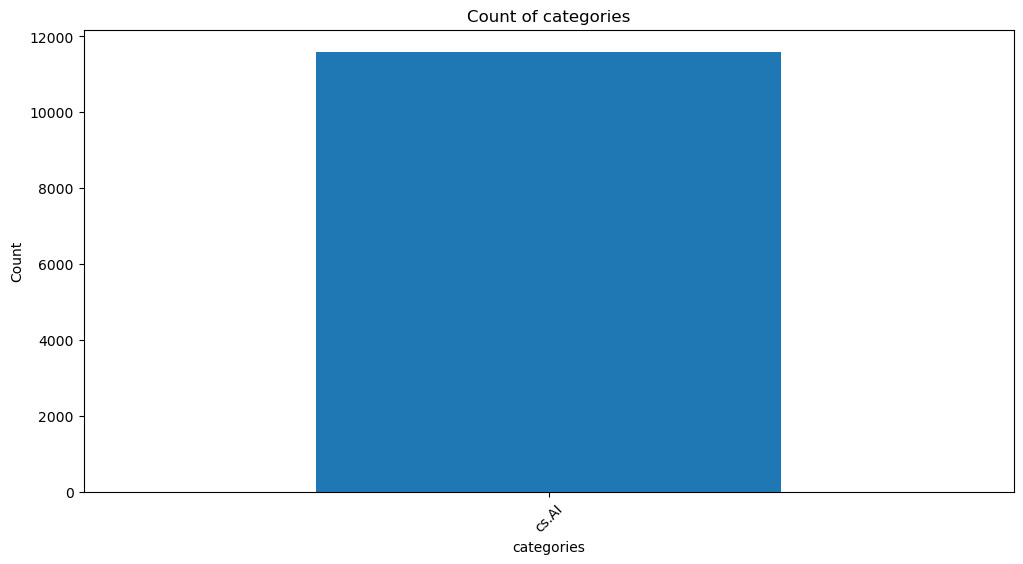

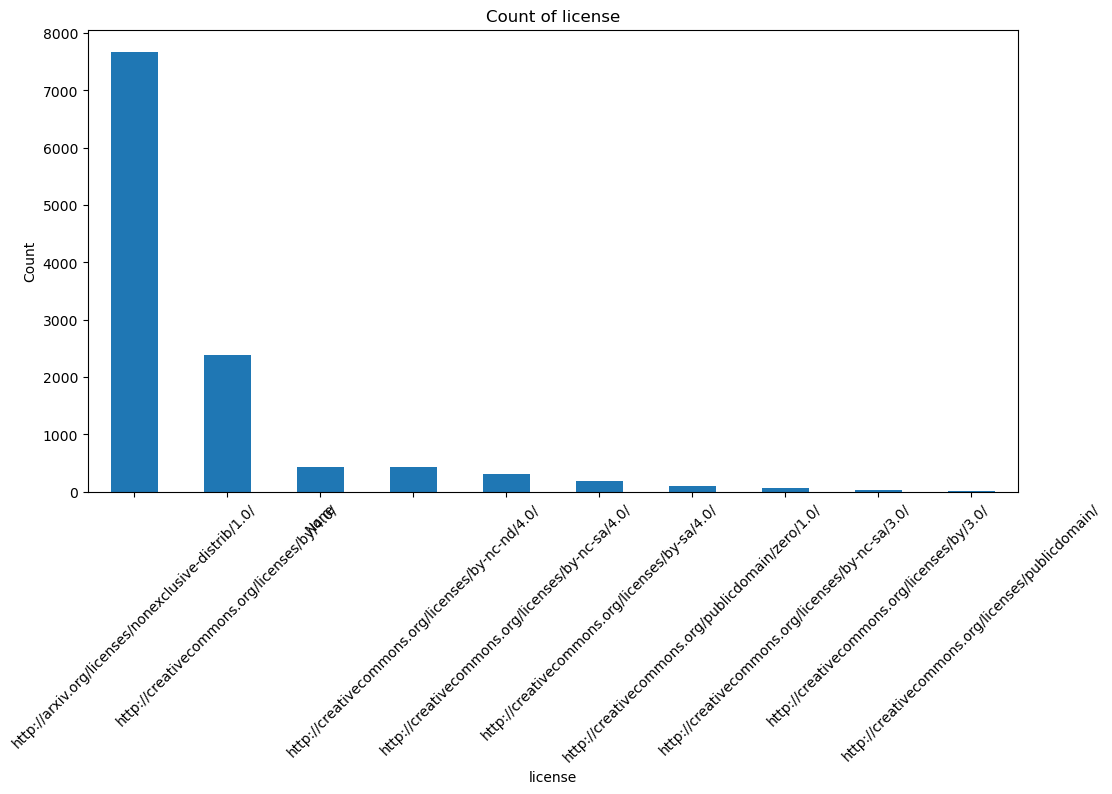

In [72]:
##### Plot data
### --- 1. Bar Plots for Categorical Columns ---

for column in categorical_columns_plot:
    if column in arxiv.columns:  # Ensure the column exists in the DataFrame
        plt.figure(figsize=(12, 6))  # Define figure size
        arxiv[column].value_counts(dropna=True).plot(kind='bar', title=f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

        # Create the filename dynamically and save figure
        filename = f"{n}_{column}_bar_plot.png"
        filepath = os.path.join(folder, filename)
        plt.savefig(filepath)  # Save figure
        plt.show()  # Display the plot
        n += 1  # Increment counter for the next iteration

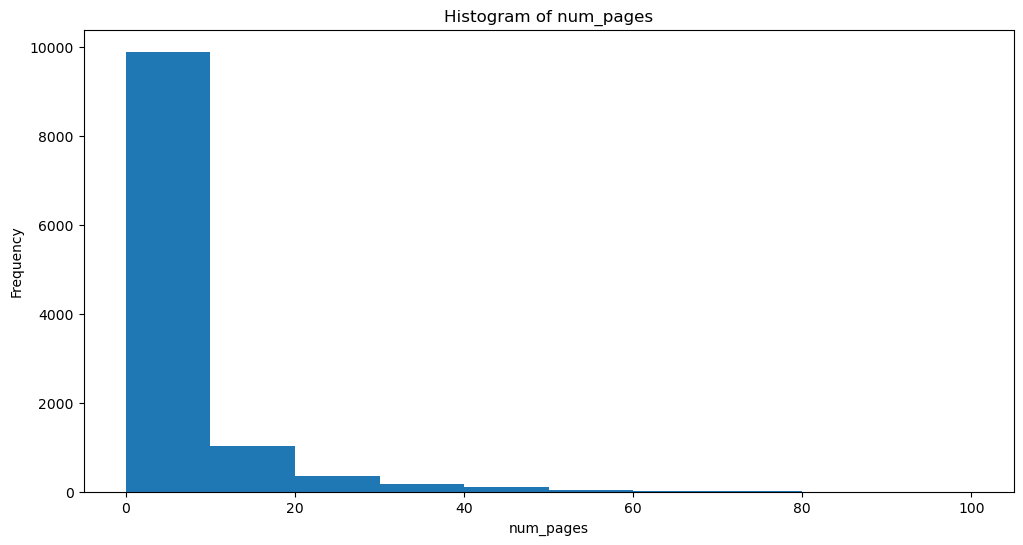

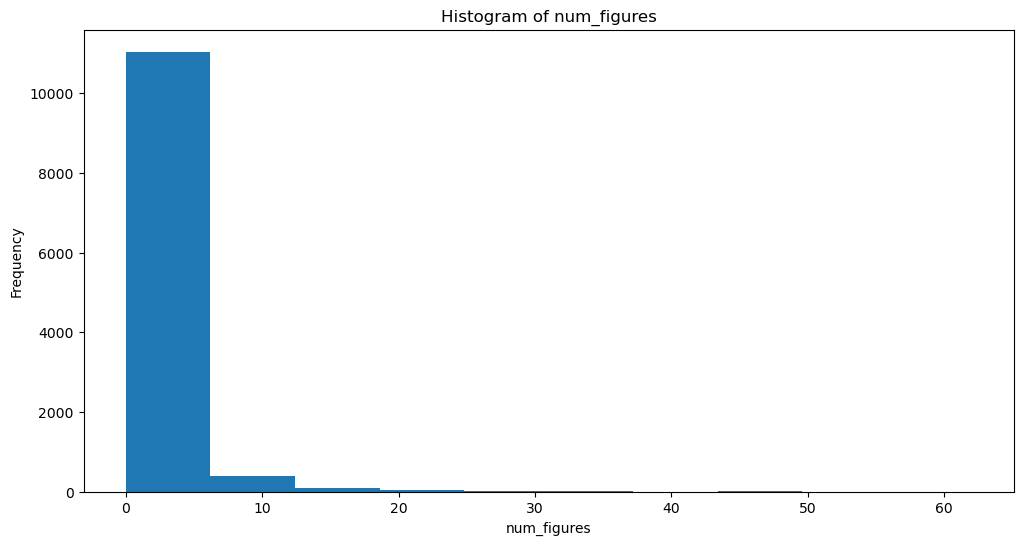

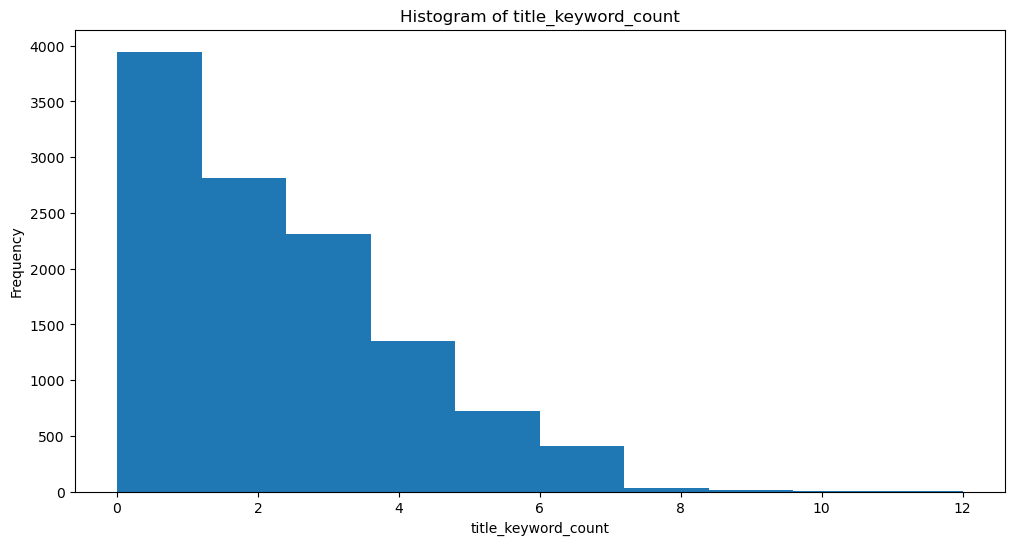

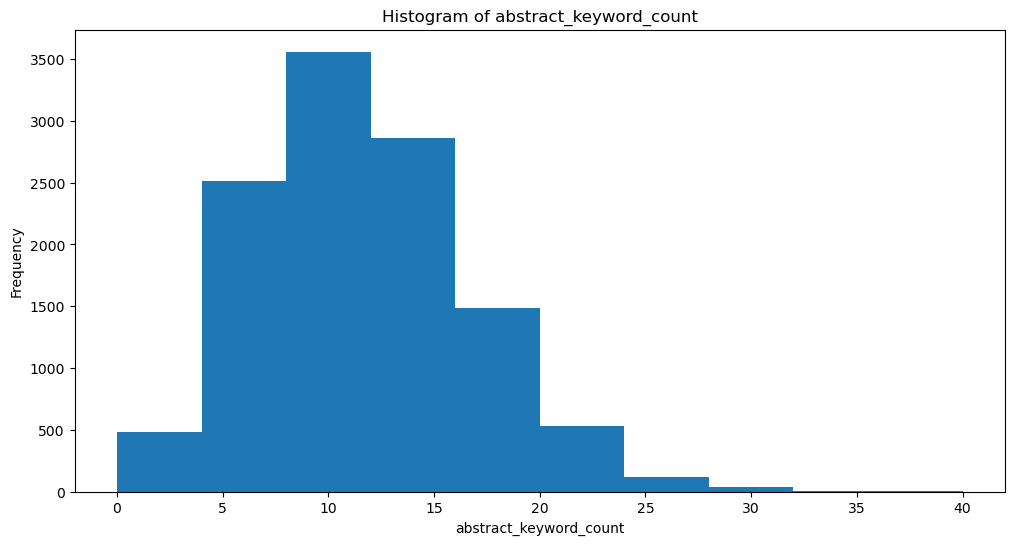

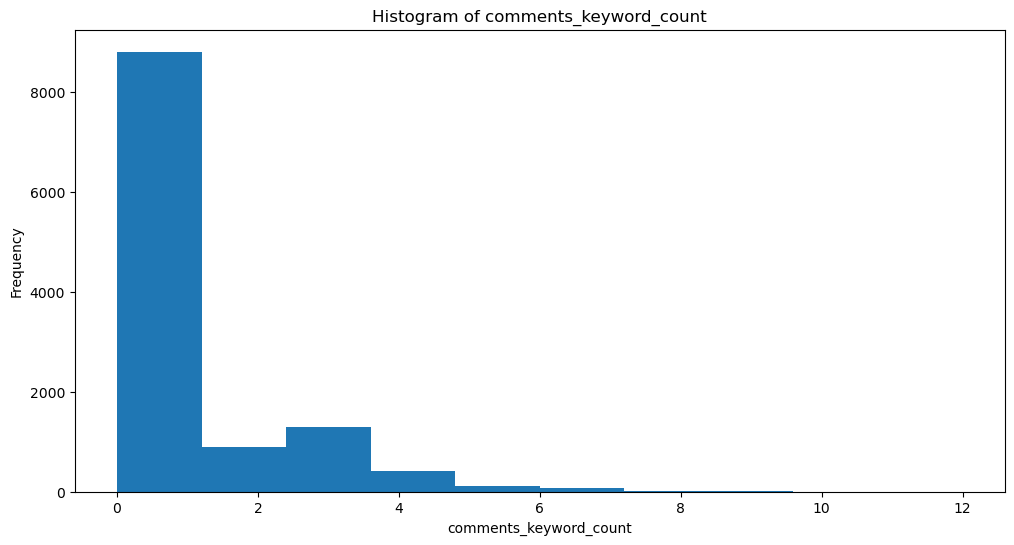

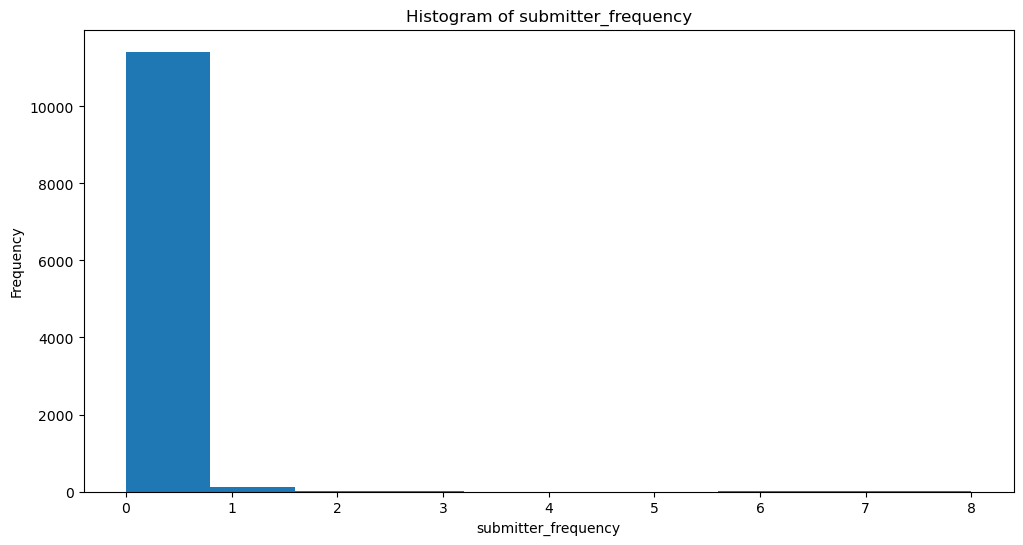

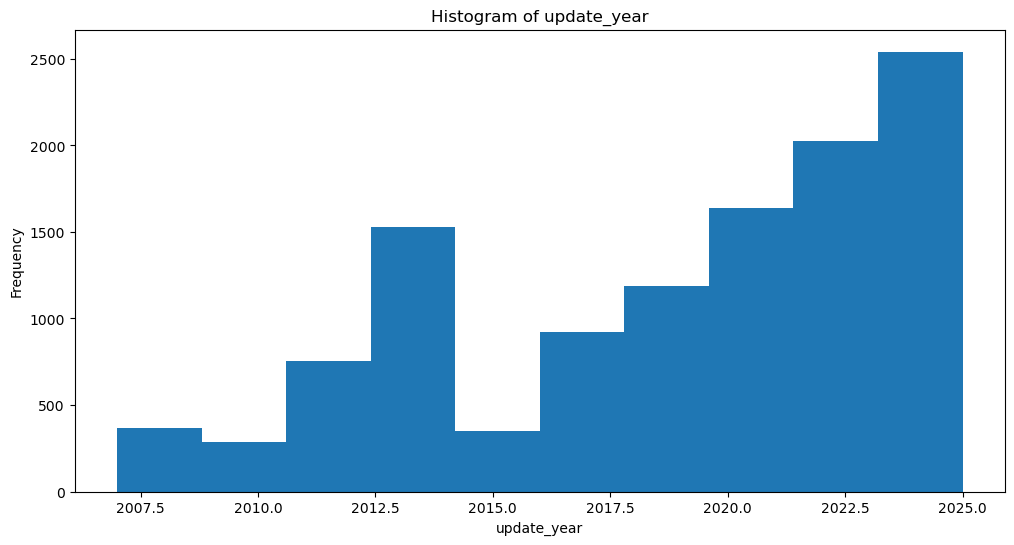

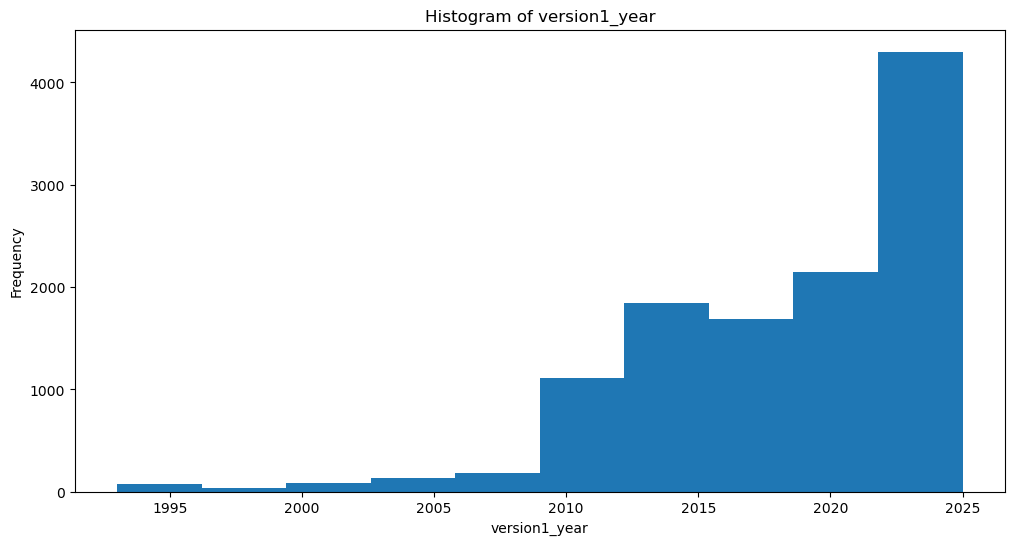

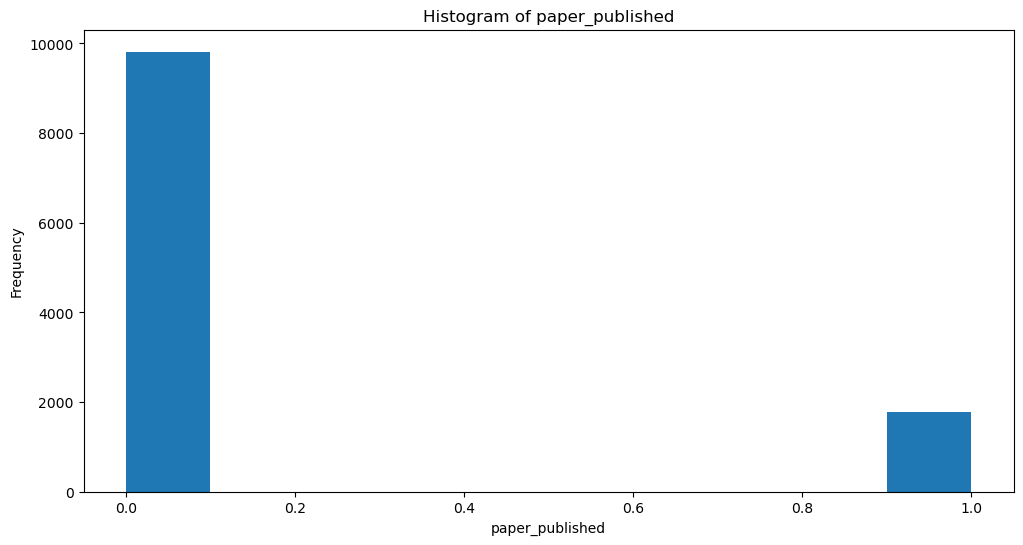

In [73]:
### --- 2. Histograms for Numerical Columns ---

for column in numerical_columns:
    if column in arxiv.columns:  # Ensure the column exists in the DataFrame
        plt.figure(figsize=(12, 6))  # Define figure size
        arxiv[column].plot(kind='hist', title=f'Histogram of {column}', bins=10)
        plt.xlabel(column)
        plt.ylabel('Frequency')

        # Create the filename dynamically and save figure
        filename = f"{n}_{column}_histogram.png"
        filepath = os.path.join(folder, filename)
        plt.savefig(filepath)  # Save figure
        plt.show()  # Display the plot
        n += 1  # Increment counter for the next iteration

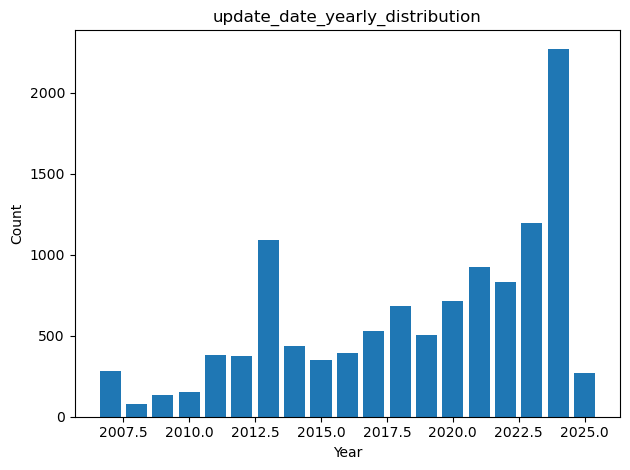

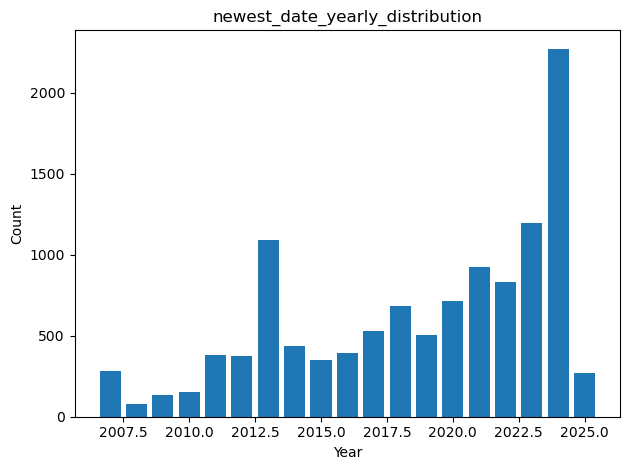

In [74]:
### --- 3. Plot Datetime Distribution ---
# Function to plot datetime columns grouped by year
columns = ['update_date', 'newest_date']

for i, column in enumerate(columns):
    if column in arxiv.columns:
        filename = f"{column}_yearly_distribution_plot.png"
        filepath = os.path.join(folder, filename)
        fig, ax = plt.subplots()
        years = arxiv[column].dt.year
        year_counts = years.value_counts().sort_index()
        ax.bar(year_counts.index, year_counts.values)
        ax.set_title(f"{column}_yearly_distribution")
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        plt.tight_layout()
        filename = f"{n}_{column}_datetime_yearly_distribution.png"
        filepath = os.path.join(folder, filename)
        plt.savefig(filepath)  # Save figure
        plt.show()  # Display the plot
        # Create the filename dynamically
        filename = f"{n}_{column}_yearly_distribution_plot.png"
        filepath = os.path.join(folder, filename)
    n += 1  # Increment counter for the next iteration

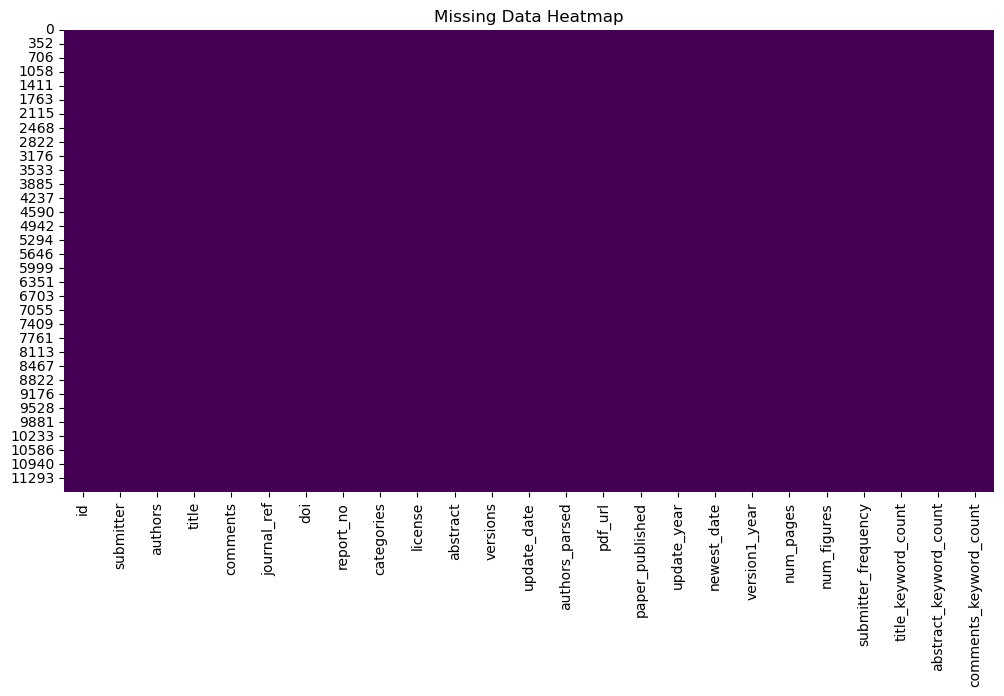

In [75]:
### --- 4. Heatmap for Missing Data ---

plt.figure(figsize=(12, 6))
sns.heatmap(arxiv.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')

# Create the filename dynamically and save figure
filename = f"{n}_missing_data_heatmap.png"
filepath = os.path.join(folder, filename)
plt.savefig(filepath)  # Save figure
plt.show()  # Display the plot
n += 1  # Increment counter for the next iteration

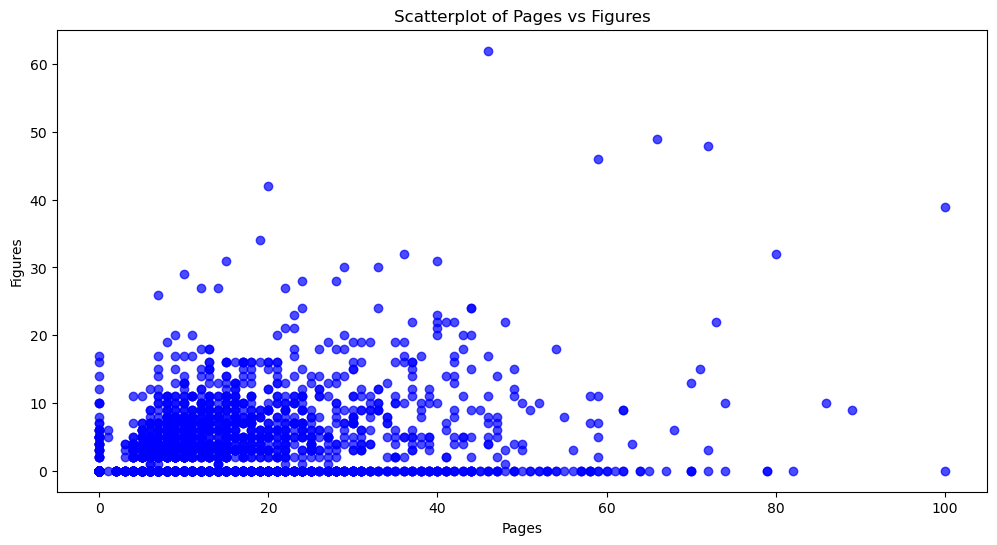

In [76]:
### --- 5. Scatterplot for Pages and Figures ---

plt.figure(figsize=(12, 6))  # Define figure size
plt.scatter(arxiv['num_pages'], arxiv['num_figures'], alpha=0.7, color='blue')

# Add labels and title
plt.title('Scatterplot of Pages vs Figures')
plt.xlabel('Pages')
plt.ylabel('Figures')

# Save the scatterplot dynamically
filename = f"{n}_pages_vs_images_scatterplot.png"
filepath = os.path.join(folder, filename)
plt.savefig(filepath)  # Save figure
plt.show() # Show the plot

In [77]:
### 3. Data Preparation - Part 2 - Preprocessing Text Data and Creating Tokens

In [84]:
###Preprocess text
# Define a function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):  # Check if the input is a string
        # Cleaning special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text
    else:
        return ''  # Return an empty string for non-string values

In [85]:
### 1) ABSTRACT COLUMN

In [86]:
# Apply text preprocessing to the column
arxiv['abstract'] = arxiv['abstract'].apply(preprocess_text)

In [87]:
###TF-IDF (Term Frequency-Inverse Document Frequency): Identifies words that are important within a document relative to a corpus.
# This method can highlight technical terms that appear frequently in your text but not in general language.
# Converts a collection of text documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features for NLP Processing to represent
# text data numerically.
# TF-IDF assigns weights to words based on their frequency in a document (term frequency) and their rarity across the entire corpus (inverse document
# frequency). Words that are frequent in one document but rare in others receive higher weights, while common words like "the" or "is" are downweighted.

def compute_tfidf(texts):
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
    
    # Fit and transform the texts to get TF-IDF vectors
    tfidf_vectors = vectorizer.fit_transform(texts)
    
    return tfidf_vectors

# Apply the function to the abstracts and store the TF-IDF vectors
tfidf_vectors = compute_tfidf(arxiv['abstract'])

# Convert the sparse matrix to a dense numpy array
tfidf_dense = tfidf_vectors.toarray()

# Store the TF-IDF vectors in new columns in the DataFrame
# Since TF-IDF vectors can be large, we'll store them as lists or arrays in a single column
arxiv['abstract_tfidf'] = [list(row) for row in tfidf_dense]

In [88]:
###K-Means Clustering
k = 5
kmeans = KMeans(n_clusters=k)
arxiv['cluster_abstract_tfidf'] = kmeans.fit_predict(tfidf_vectors)

In [89]:
###Principal Component Analysis (PCA) for Dimensionality Reduction
# Apply PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(tfidf_vectors.toarray())

In [90]:
###Adjust folder
#folder = 'C:/Users/mnkub/Desktop/Capstone/images/'  # Define the folder where images will be saved
folder = '../images/'  # Define the folder where images will be saved

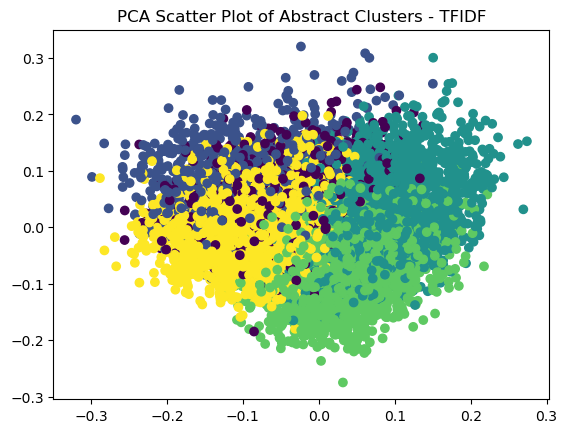

In [91]:
###Visualitation: Scatter Plot of the Clusters
plt.scatter(pca_result[:,0],pca_result[:,1], c=arxiv['cluster_abstract_tfidf'], cmap='viridis')
plt.title('PCA Scatter Plot of Abstract Clusters - TFIDF')

# Save the scatterplot dynamically
n += 1
filename = f"{n}_PCA_TFIDF_abstract_scatterplot.png"
filepath = os.path.join(folder, filename)
plt.savefig(filepath)  # Save figure
#plt.savefig('../images/_PCA_abstract_scatterplot.png') #adjust folder when fisnihed using the GIT structure
plt.show()

In [92]:
# Download required NLTK resources
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mnkub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mnkub\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnkub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mnkub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

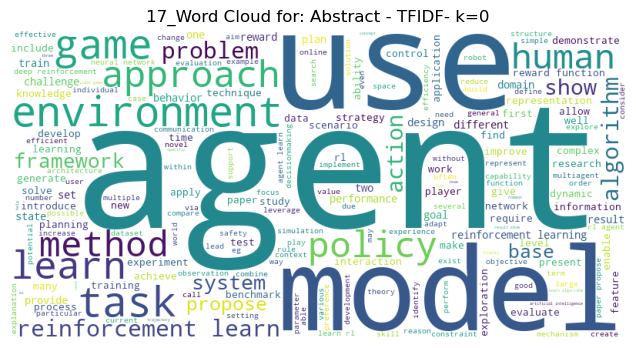

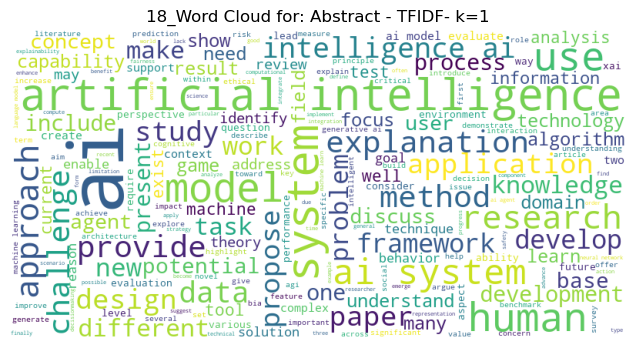

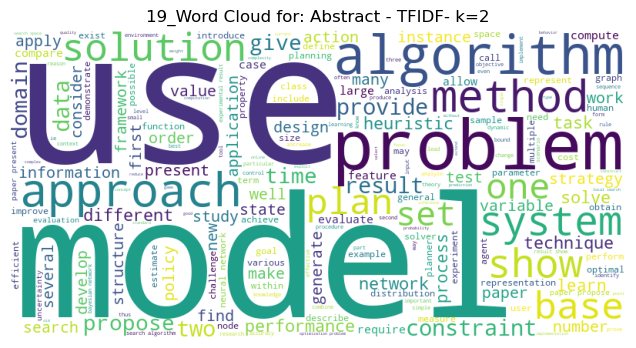

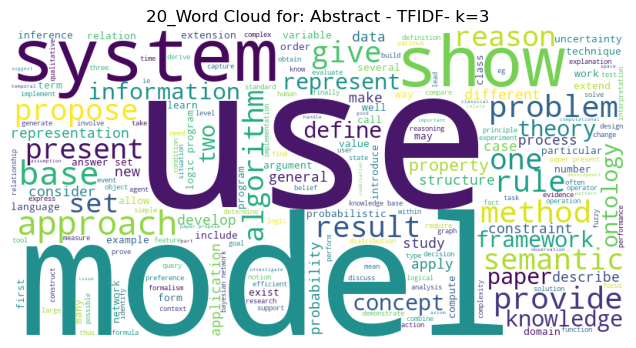

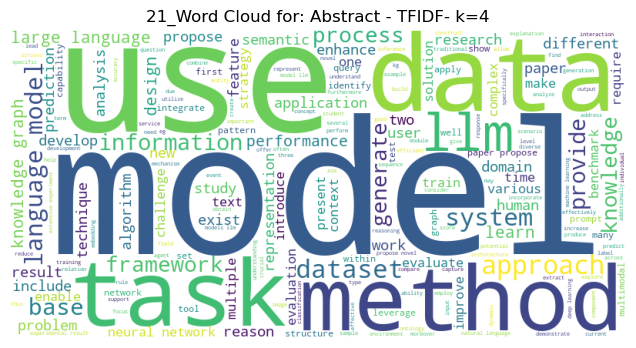

In [93]:
###Word Cloud for the Clusters
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_abstract_tfidf']==cluster]['abstract'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_cluster_text)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud)

    #plt.title(f'Word Cloud for ARXIV.org Metadata - cs.AI')
    n += 1
    plt.title(f"{n}_Word Cloud for: Abstract - TFIDF- k={cluster}")
    plt.axis('off')

    # Save the scatterplot dynamically
    filename = f"{n}_wordcloud_TFIDF_abstract_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure
    plt.savefig(filename)

    #plt.savefig('../images/wordcloud_abstract_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

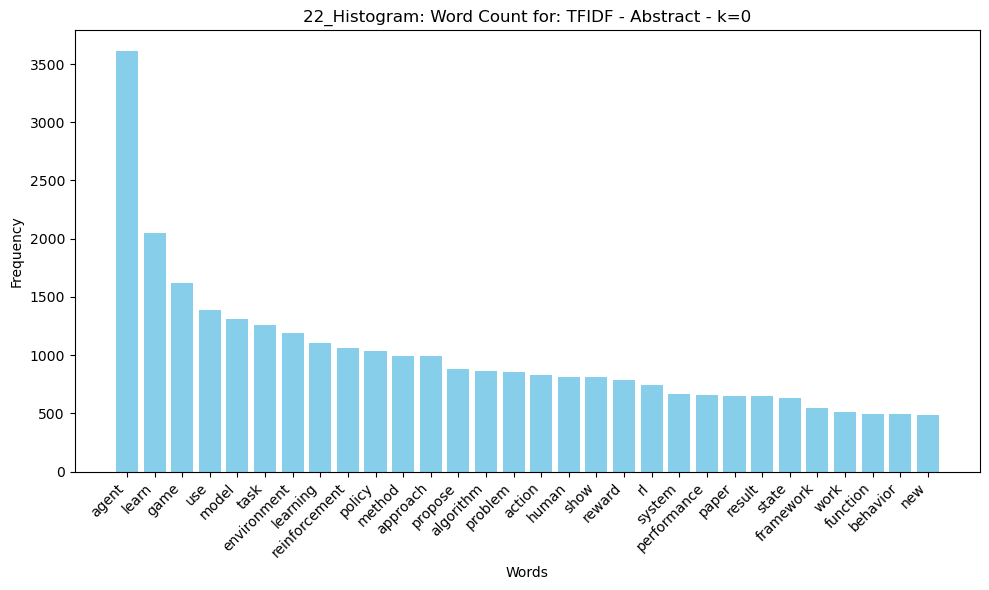

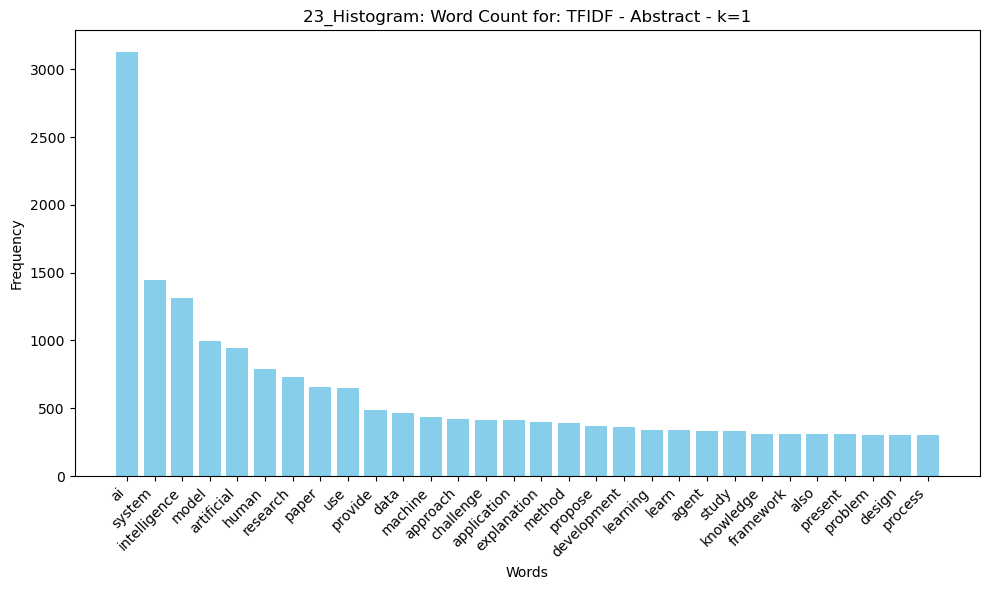

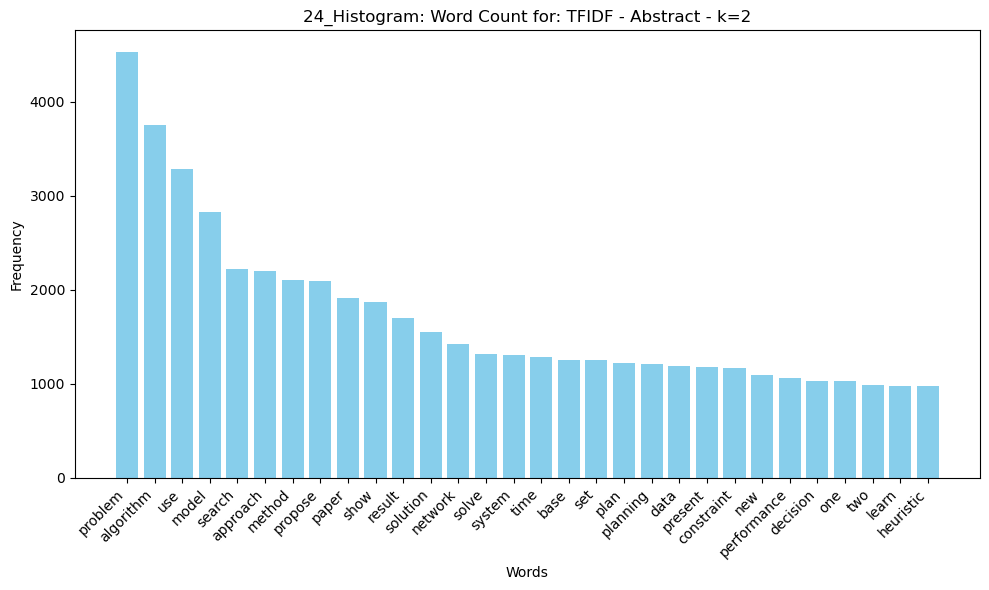

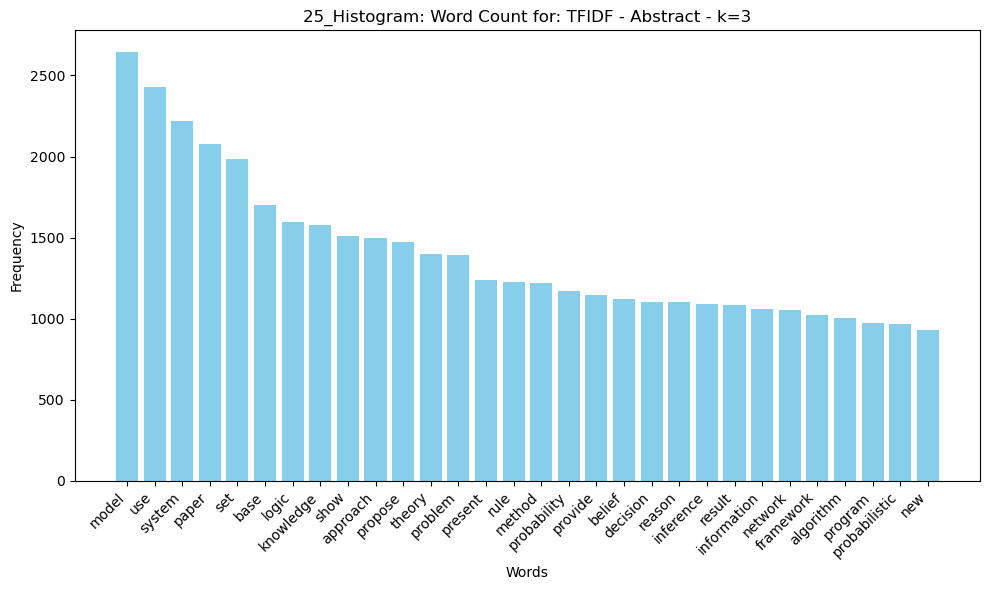

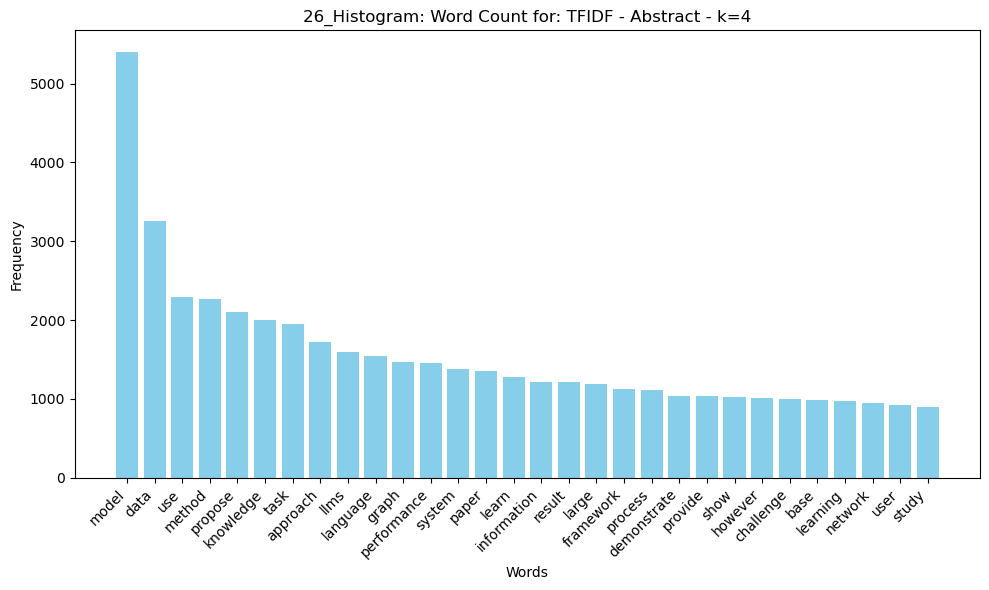

In [94]:
###Counting Words and Plotting an Histogram

# Apply Counter to each row in the 'abstract' column
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_abstract_tfidf']==cluster]['abstract'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)    
    
    word_counts = Counter(cleaned_cluster_text.split())  #Step 3: Count word frequencies
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])  # Step 4: Convert to a DataFrame for easier handling
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)  # Step 5: Sort by frequency in descending order
    top_n = 30  ## Step 4: Plot the top N words (e.g., top 20)
    plt.figure(figsize=(10,6))
    plt.bar(word_counts_df['Word'][:top_n], word_counts_df['Frequency'][:top_n], color='skyblue')
    plt.xticks(rotation=45, ha='right')

    n += 1
    plt.title(f'{n}_Histogram: Word Count for: TFIDF - Abstract - k={cluster}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Save the scatterplot dynamically
    filename = f"{n}_wordcount_TFIDF_abstract_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure
    plt.savefig(filename)

    #plt.savefig('../images/wordcount_abstract_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

In [95]:
### 1) TITLE COLUMN

In [96]:
# Apply text preprocessing to the column
arxiv['title'] = arxiv['title'].apply(preprocess_text)

In [97]:
###TF-IDF (Term Frequency-Inverse Document Frequency): Identifies words that are important within a document relative to a corpus.

def compute_tfidf(texts):
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
    
    # Fit and transform the texts to get TF-IDF vectors
    tfidf_vectors = vectorizer.fit_transform(texts)
    
    return tfidf_vectors

# Apply the function to the titles and store the TF-IDF vectors
tfidf_vectors = compute_tfidf(arxiv['title'])

# Convert the sparse matrix to a dense numpy array
tfidf_dense = tfidf_vectors.toarray()

# Store the TF-IDF vectors in new columns in the DataFrame
# Since TF-IDF vectors can be large, we'll store them as lists or arrays in a single column
arxiv['title_tfidf'] = [list(row) for row in tfidf_dense]

In [98]:
###K-Means Clustering
k = 5
kmeans = KMeans(n_clusters=k)
arxiv['cluster_title_tfidf'] = kmeans.fit_predict(tfidf_vectors)

In [99]:
###Principal Component Analysis (PCA) for Dimensionality Reduction
# Apply PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(tfidf_vectors.toarray())

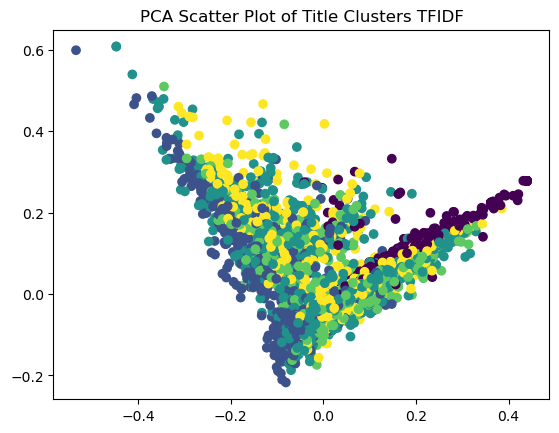

In [100]:
###Visualitation: Scatter Plot of the Clusters
plt.scatter(pca_result[:,0],pca_result[:,1], c=arxiv['cluster_title_tfidf'], cmap='viridis')
plt.title('PCA Scatter Plot of Title Clusters TFIDF')

# Save the scatterplot dynamically
n += 1

filename = f"{n}_PCA_TFIDF_title_scatterplot.png"
filepath = os.path.join(folder, filename)
plt.savefig(filepath)  # Save figure
#plt.savefig('../images/_PCA_title_scatterplot.png') #adjust folder when fisnihed using the GIT structure
plt.show()

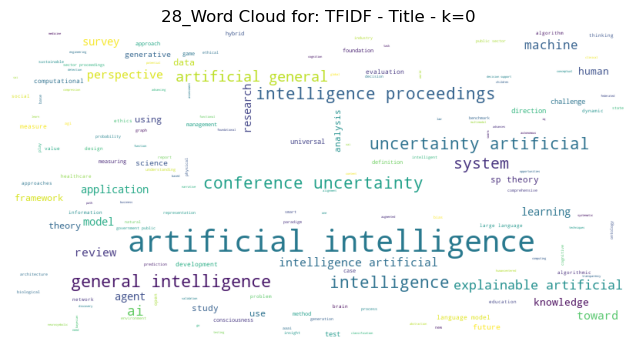

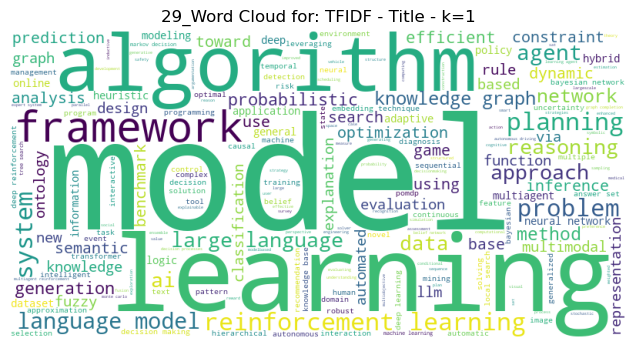

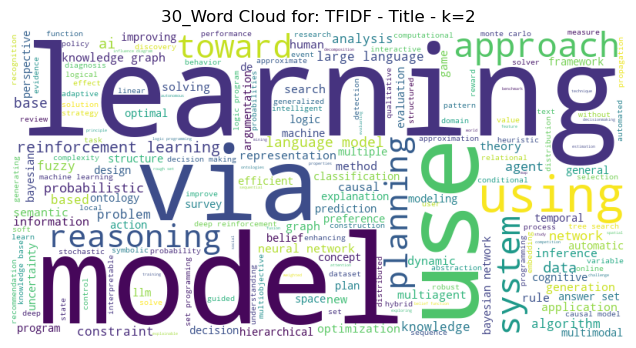

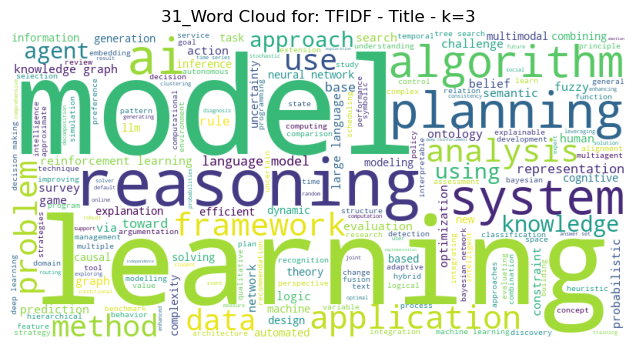

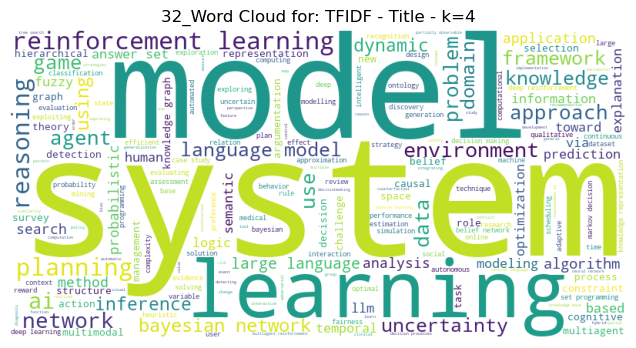

In [101]:
###Word Cloud for the Clusters
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_title_tfidf']==cluster]['title'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_cluster_text)

    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud)

    #plt.title(f'Word Cloud for ARXIV.org Metadata - cs.AI')
    n += 1
    plt.title(f"{n}_Word Cloud for: TFIDF - Title - k={cluster}")
    plt.axis('off')

    # Save the scatterplot dynamically
    filename = f"{n}_wordcloud_TFIDF_title_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure
    plt.savefig(filename)

    #plt.savefig('../images/wordcloud_title_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

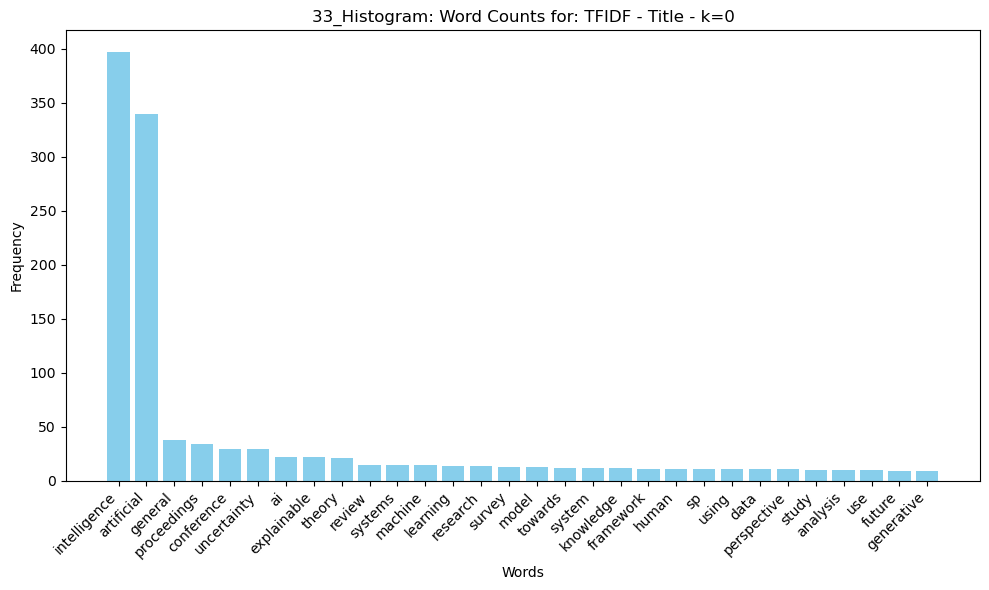

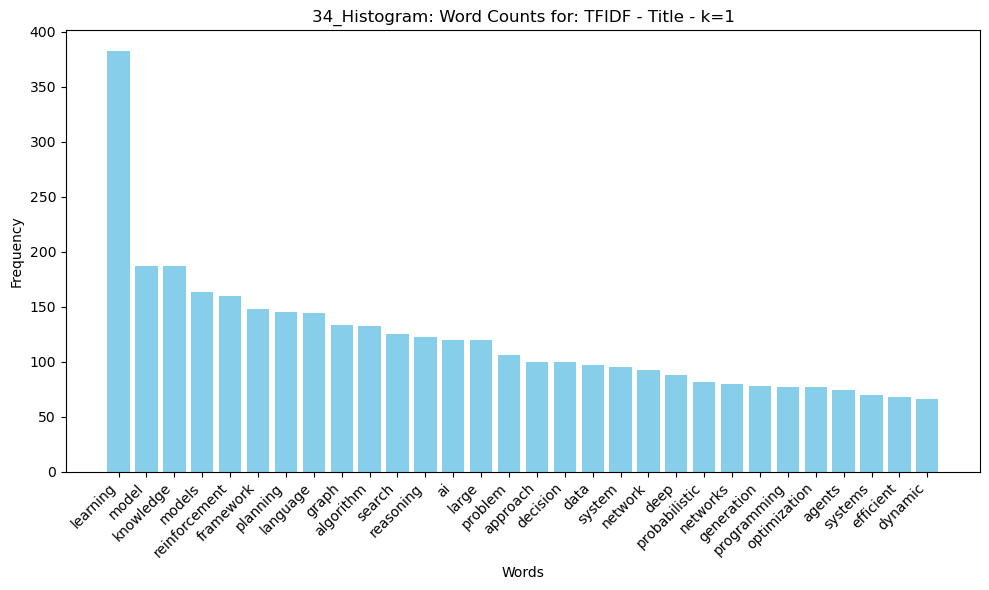

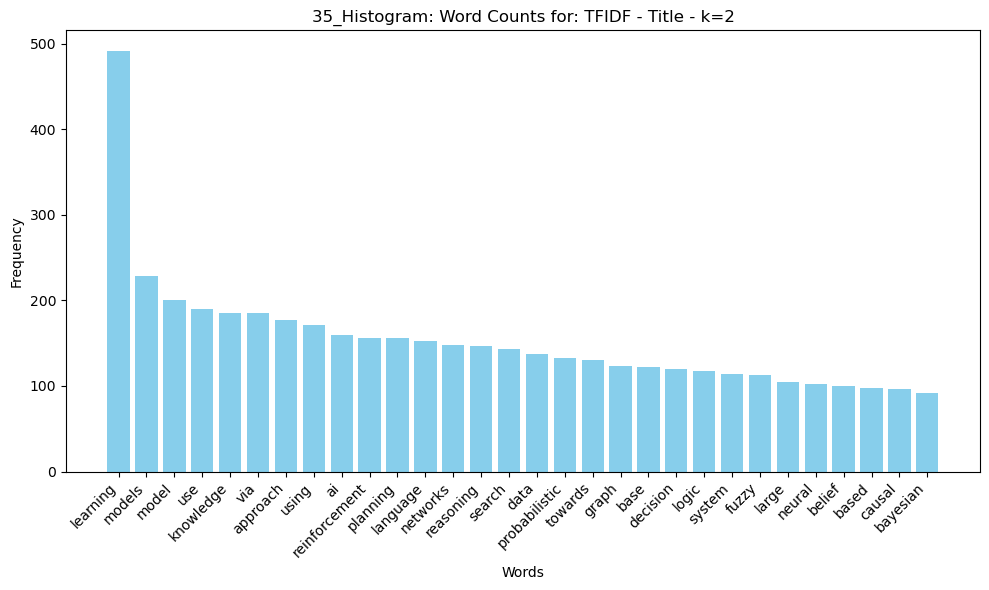

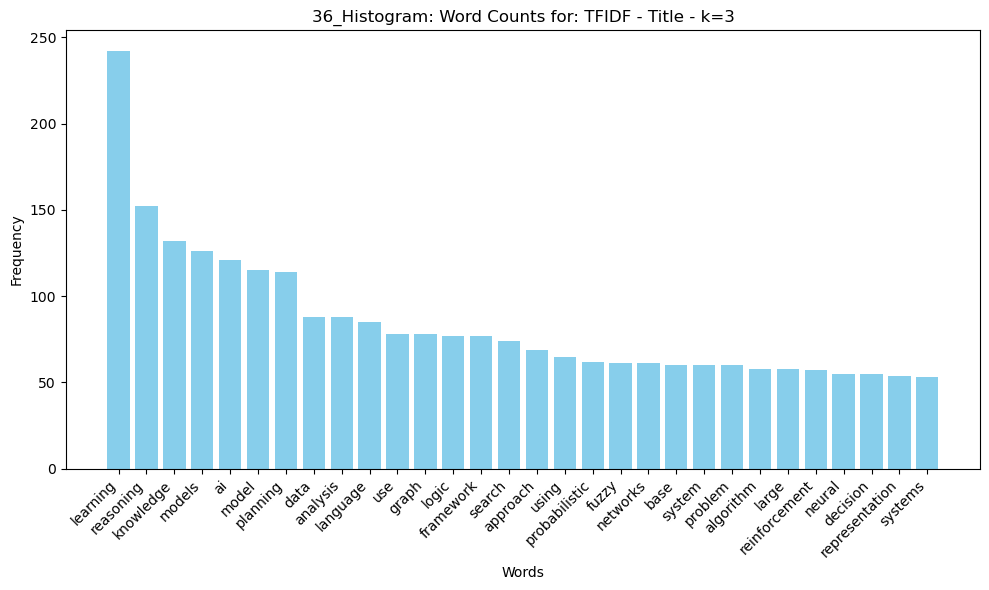

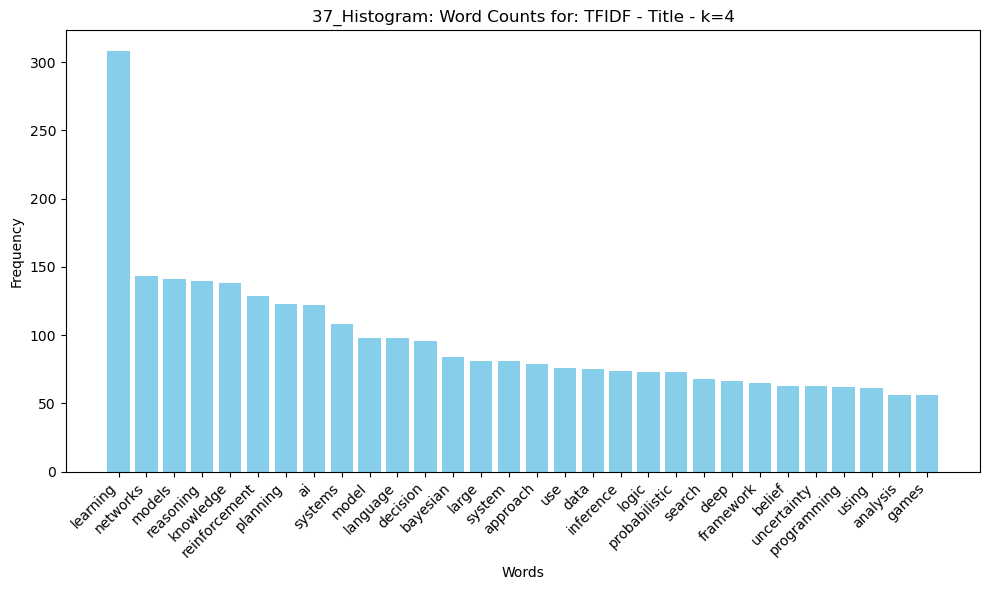

In [102]:
###Counting Words and Plotting an Histogram

# Apply Counter to each row in the 'abstract' column
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_title_tfidf']==cluster]['title'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)    

    word_counts = Counter(cleaned_cluster_text.split())  #Step 3: Count word frequencies
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])  # Step 4: Convert to a DataFrame for easier handling
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)  # Step 5: Sort by frequency in descending order
    top_n = 30  ## Step 4: Plot the top N words (e.g., top 20)
    plt.figure(figsize=(10,6))
    plt.bar(word_counts_df['Word'][:top_n], word_counts_df['Frequency'][:top_n], color='skyblue')
    plt.xticks(rotation=45, ha='right')

    n += 1
    plt.title(f'{n}_Histogram: Word Counts for: TFIDF - Title - k={cluster}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Save the scatterplot dynamically
    filename = f"{n}_wordcount_TFIDF_title_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure
    plt.savefig(filename)

    #plt.savefig('../images/wordcount_title_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

In [103]:
###BERT - Preprocessng text data and creating tokens

In [104]:
##### BERT model

# Load tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()  # Important: we're NOT fine-tuning

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [105]:
### Function to preprocess text data
def preprocess_text(texts):
    inputs = tokenizer(texts, return_tensors='pt', max_length=16, padding=True, truncation=True)
    return inputs

In [106]:
### ABSTRACT COLUMN

In [107]:
### Preprocess abstract
abstracts = arxiv['abstract'].tolist()  # Ensure it's a list
inputs = preprocess_text(abstracts)

In [108]:
### Compute embeddings
def compute_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=16, truncation=True, padding=True)
    outputs = model(**inputs)
    # Use the last hidden state of the first token (CLS token) as the embedding
    embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()[0]
    return embedding

# Apply the function to each abstract and store the embeddings in a new column
arxiv['abstract_embedding_bert'] = arxiv['abstract'].apply(compute_embedding)

In [109]:
# Convert the embeddings column to a numpy array
embeddings = np.array(arxiv['abstract_embedding_bert'].tolist())

In [110]:
# Apply PCA to reduce embeddings to 128 dimensions
# Ensure n_components is valid based on the number of samples and features
n_components = min(128, embeddings.shape[0], embeddings.shape[1])
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings)

In [111]:
# Save reduced embeddings
arxiv['abstract_reduced_embeddings_bert'] = [list(row) for row in reduced_embeddings]

In [112]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
arxiv['cluster_abstract_bert'] = kmeans.fit_predict(embeddings)

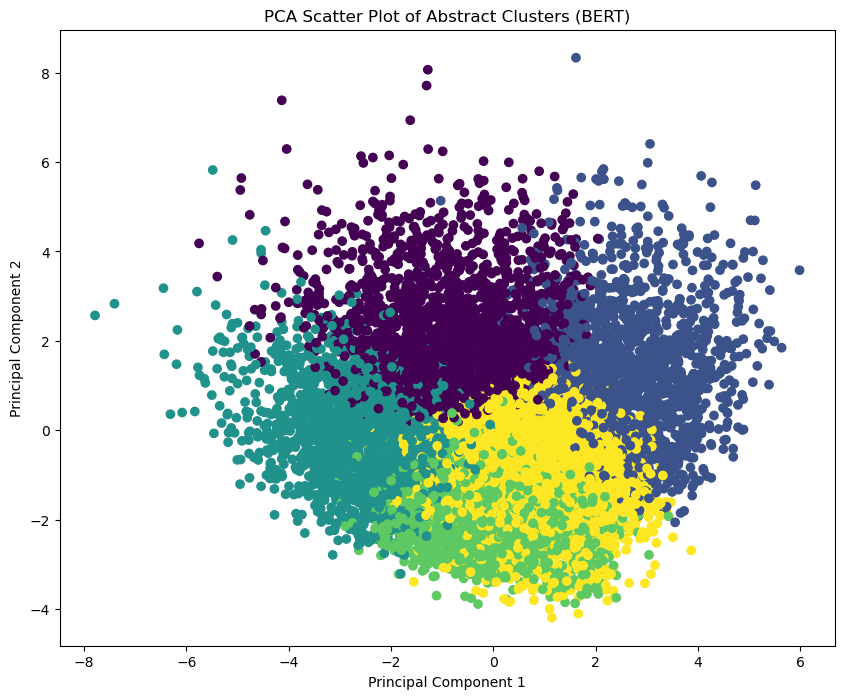

In [113]:
###Visualitation: Scatter Plot of the Clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=arxiv['cluster_abstract_bert'], cmap='viridis')
plt.title('PCA Scatter Plot of Abstract Clusters (BERT)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Save the scatterplot dynamically
filename = f"{n}_wordcount_BERT_abstract.png"
filepath = os.path.join(folder, filename)
plt.savefig(filepath)  # Save figure to the specified path
plt.show()

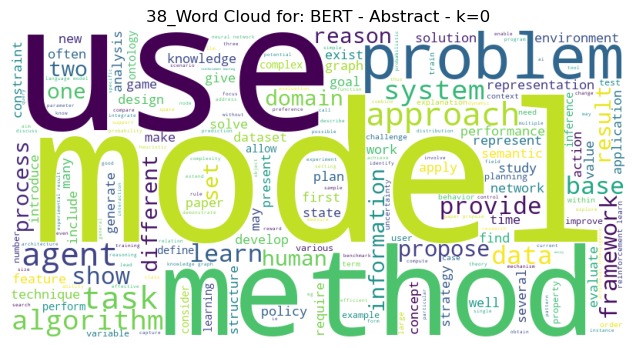

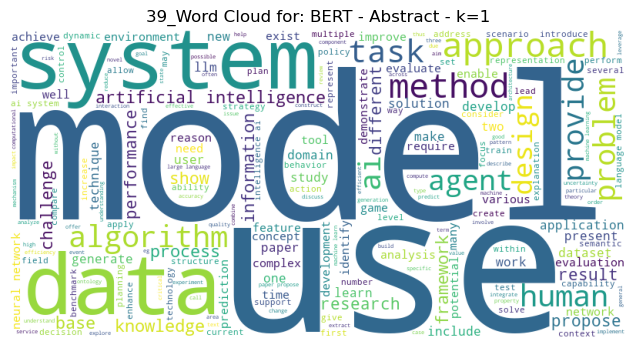

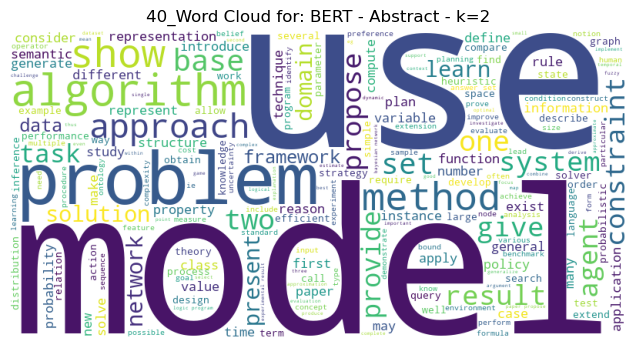

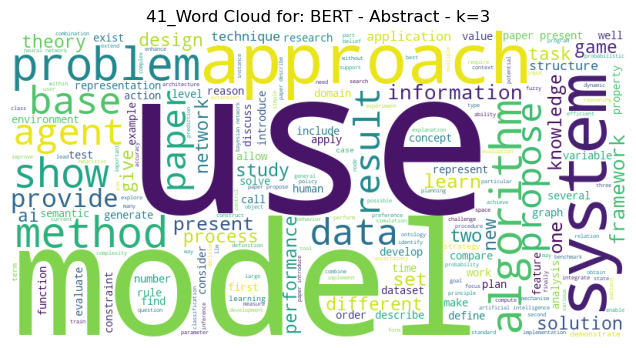

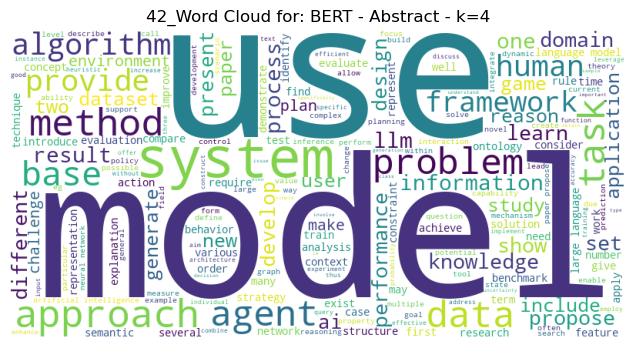

In [114]:
###Word Cloud for the Clusters
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_abstract_bert']==cluster]['abstract'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_cluster_text)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud)

    #plt.title(f'Word Cloud for ARXIV.org Metadata - cs.AI')
    n += 1
    plt.title(f"{n}_Word Cloud for: BERT - Abstract - k={cluster}")
    plt.axis('off')

    # Save the scatterplot dynamically
    filename = f"{n}_wordcloud_BERT_abstract_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure to the specified path
    #plt.savefig('../images/wordcloud_title_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

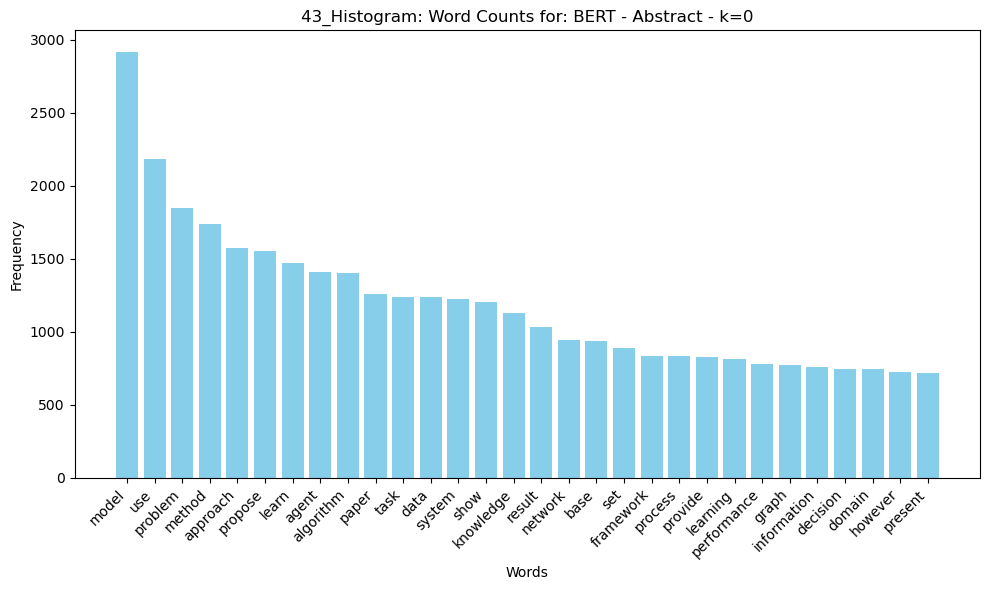

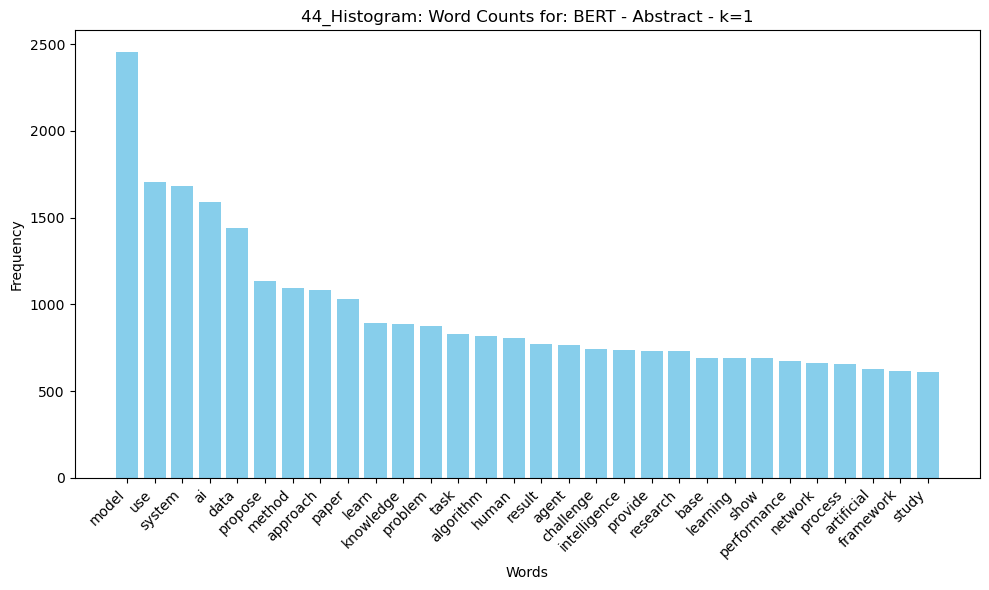

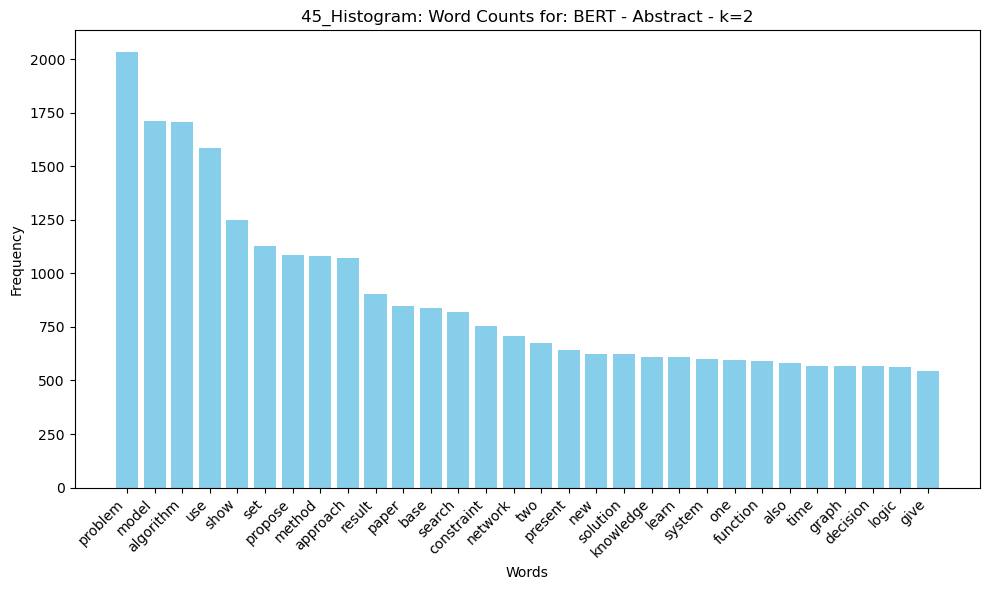

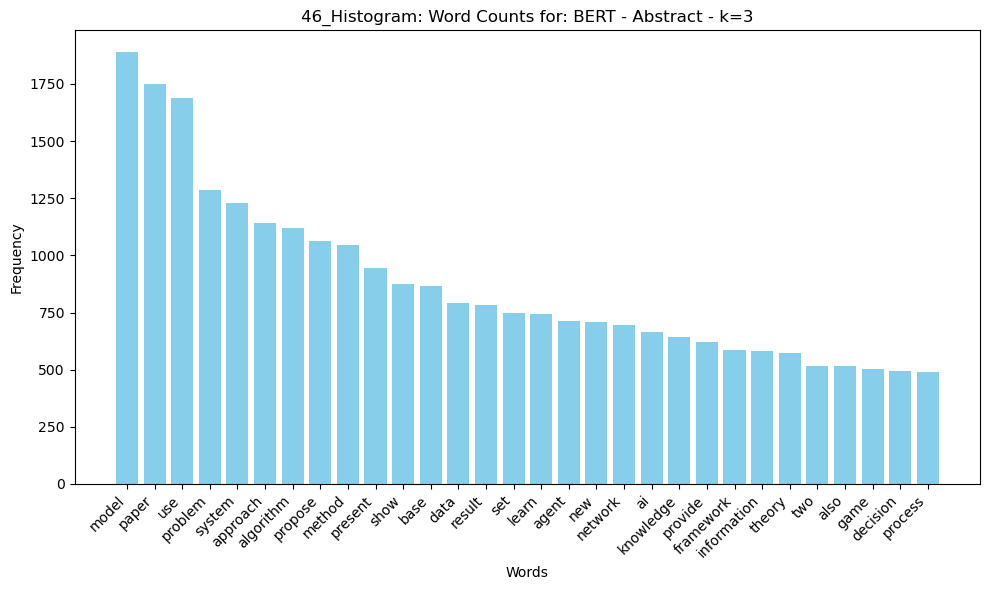

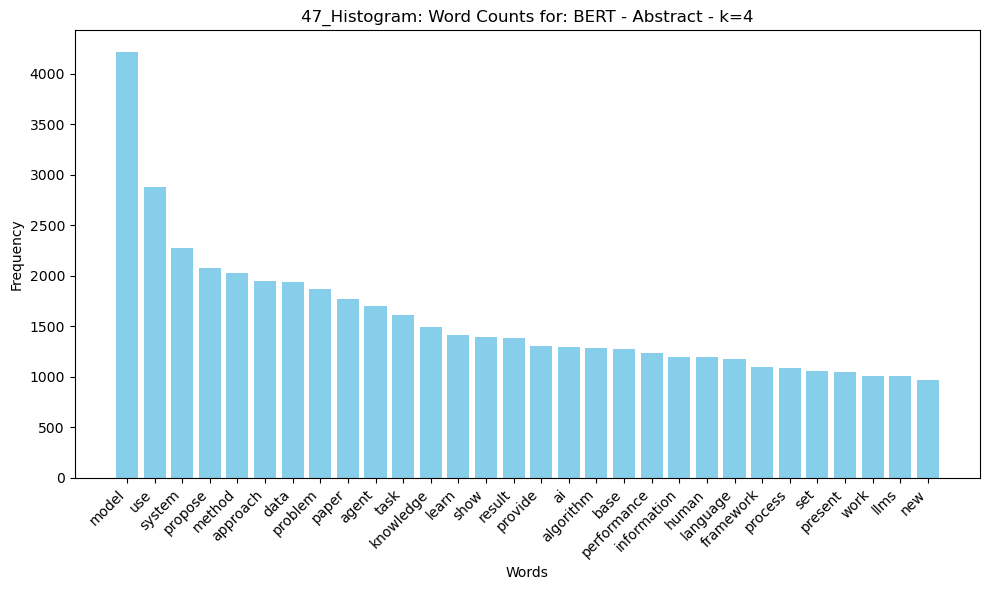

In [115]:
###Counting Words and Plotting an Histogram

# Apply Counter to each row in the 'abstract' column
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_abstract_bert']==cluster]['abstract'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)
    
    word_counts = Counter(cleaned_cluster_text.split())  #Step 3: Count word frequencies
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])  # Step 4: Convert to a DataFrame for easier handling
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)  # Step 5: Sort by frequency in descending order
    top_n = 30  ## Step 4: Plot the top N words (e.g., top 20)
    plt.figure(figsize=(10,6))
    plt.bar(word_counts_df['Word'][:top_n], word_counts_df['Frequency'][:top_n], color='skyblue')
    plt.xticks(rotation=45, ha='right')

    n += 1
    plt.title(f'{n}_Histogram: Word Counts for: BERT - Abstract - k={cluster}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Save the scatterplot dynamically
    filename = f"{n}_wordcount_BERT_abstract_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure
    plt.savefig(filename)

    #plt.savefig('../images/wordcount_title_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

In [116]:
### TITLE COLUMN

In [117]:
### Preprocess title
abstracts = arxiv['title'].tolist()  # Ensure it's a list
inputs = preprocess_text(abstracts)

In [118]:
# Compute embeddings - same function as before
def compute_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=16, truncation=True, padding=True)
    outputs = model(**inputs)
    # Use the last hidden state of the first token (CLS token) as the embedding
    embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()[0]
    return embedding

# Apply the function to each abstract and store the embeddings in a new column
arxiv['title_embedding_bert'] = arxiv['title'].apply(compute_embedding)

In [119]:
# Convert the embeddings column to a numpy array
embeddings = np.array(arxiv['title_embedding_bert'].tolist())

In [120]:
# Apply PCA to reduce embeddings to 128 dimensions
# Ensure n_components is valid based on the number of samples and features
n_components = min(128, embeddings.shape[0], embeddings.shape[1])
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings)

In [121]:
# Save reduced embeddings
arxiv['title_reduced_embeddings_bert'] = [list(row) for row in reduced_embeddings]

In [122]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
arxiv['cluster_title_bert'] = kmeans.fit_predict(embeddings)

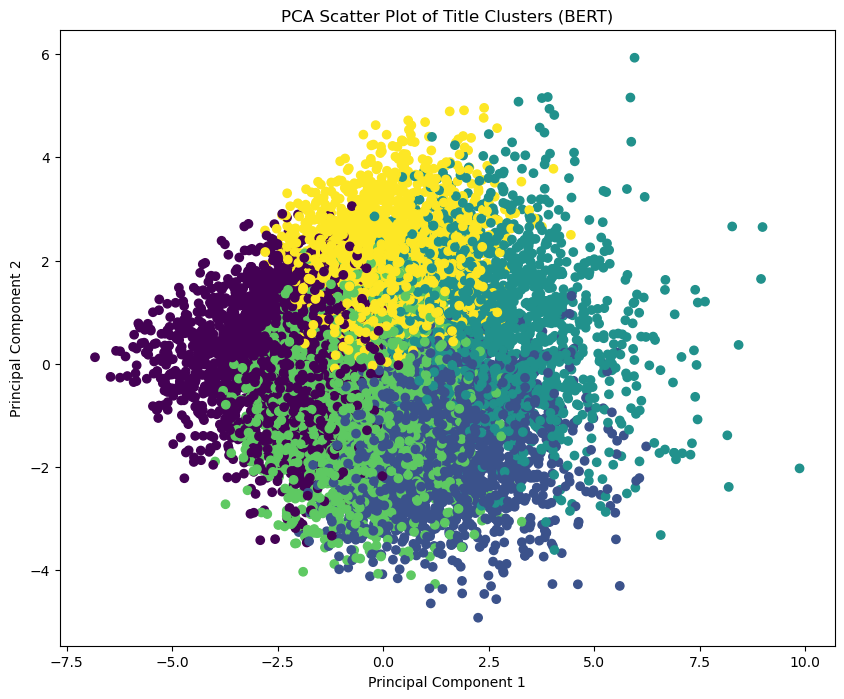

In [123]:
###Visualitation: Scatter Plot of the Clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=arxiv['cluster_title_bert'], cmap='viridis')
plt.title('PCA Scatter Plot of Title Clusters (BERT)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Save the scatterplot dynamically
filename = f"{n}_wordcount_BERT_title.png"
filepath = os.path.join(folder, filename)
plt.savefig(filepath)  # Save figure to the specified path
plt.show()

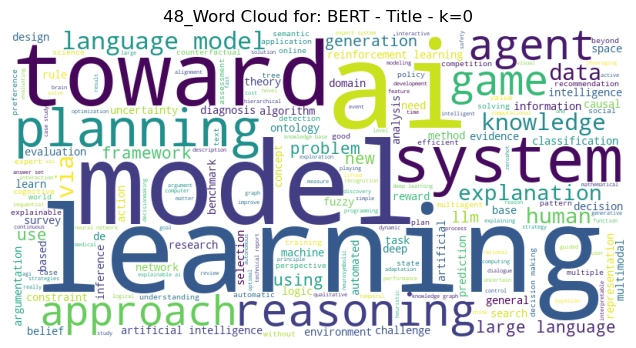

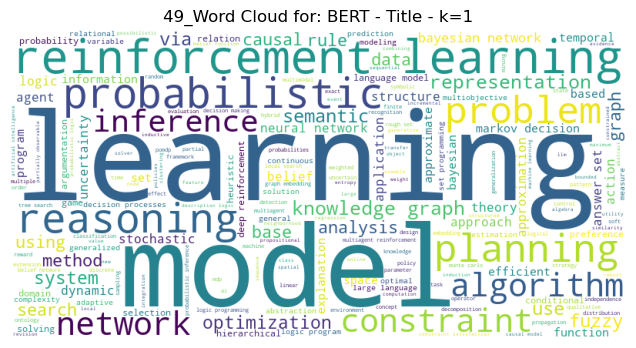

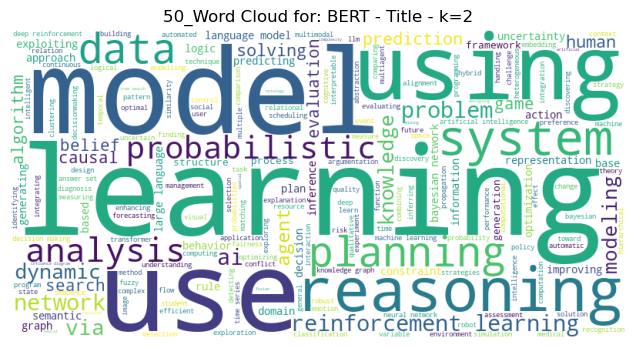

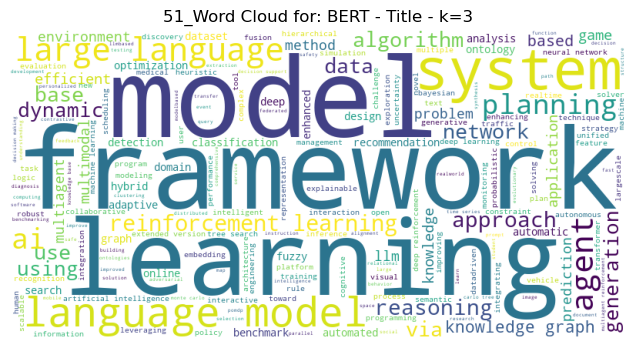

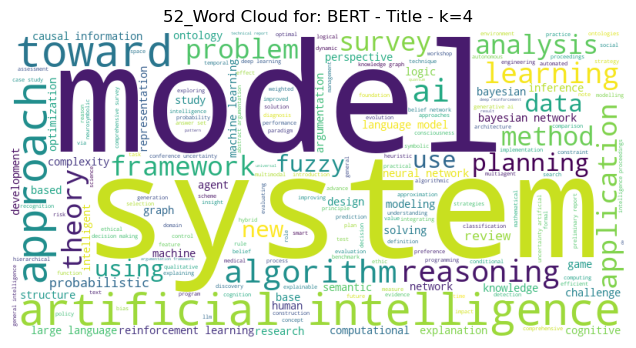

In [124]:
###Word Cloud for the Clusters
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_title_bert']==cluster]['title'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_cluster_text)

    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud)

    #plt.title(f'Word Cloud for ARXIV.org Metadata - cs.AI')
    n += 1
    plt.title(f"{n}_Word Cloud for: BERT - Title - k={cluster}")
    plt.axis('off')

    # Save the scatterplot dynamically
    filename = f"{n}_wordcloud_BERT_title_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure to the specified path
    #plt.savefig('../images/wordcloud_title_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

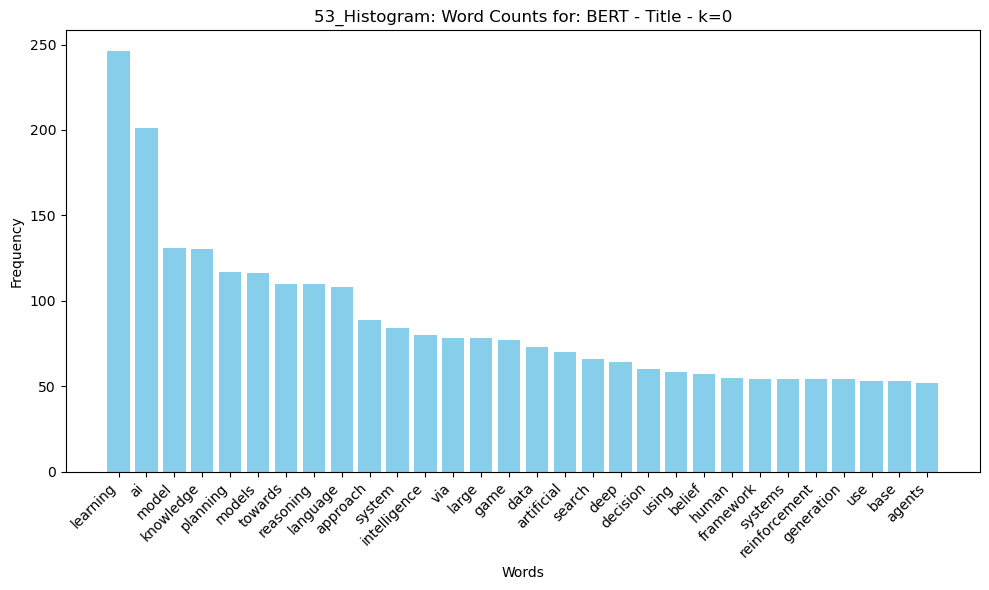

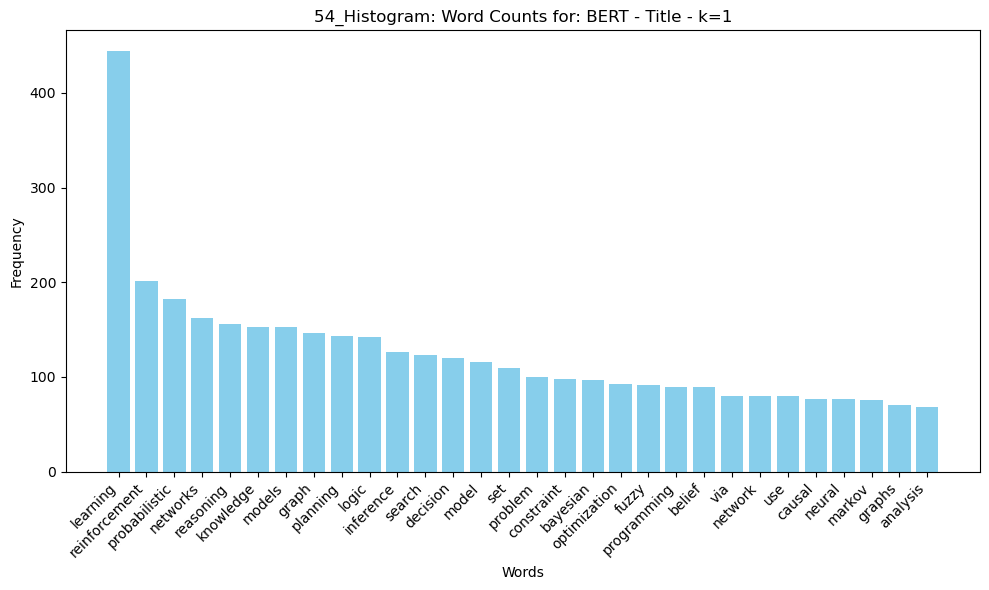

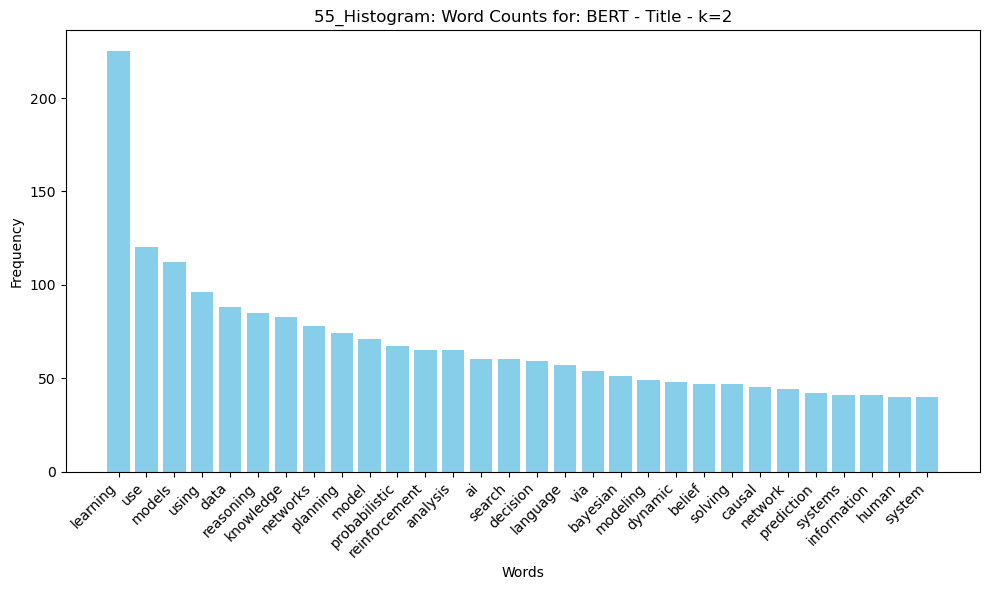

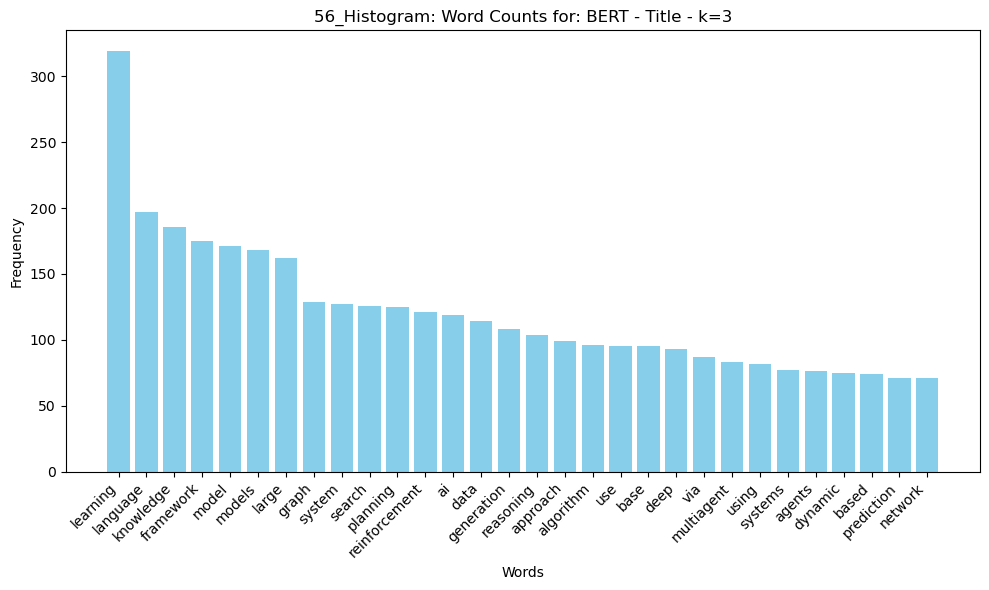

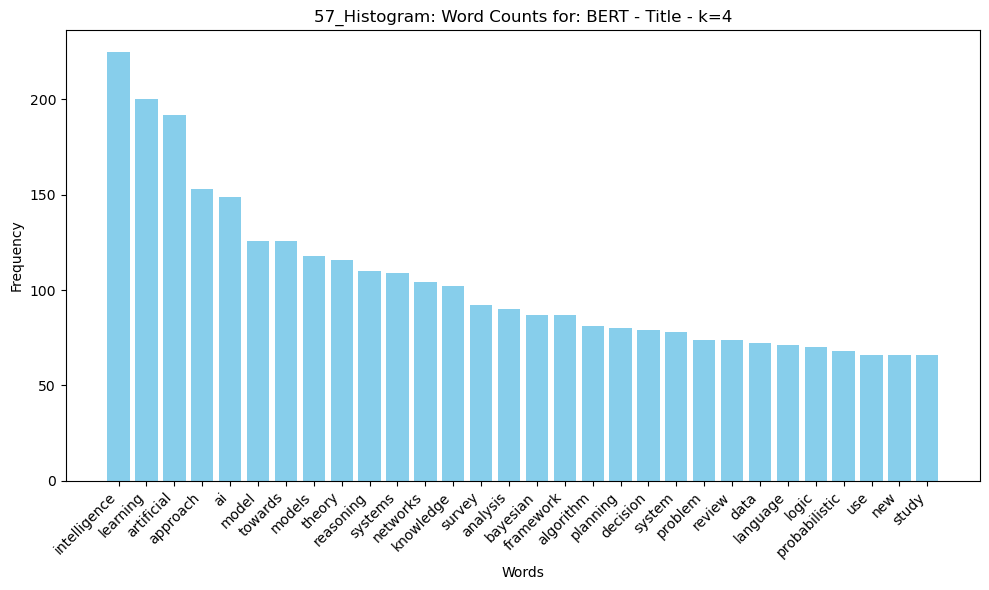

In [125]:
###Counting Words and Plotting an Histogram

# Apply Counter to each row in the 'abstract' column
k = 5

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# POS tag converter function
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet format"""
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun

for cluster in range(k):
    cluster_text = ' '.join(arxiv[arxiv['cluster_title_bert']==cluster]['title'])
    nltk_stopwords = set(stopwords.words('english'))
    
    # Tokenize with POS tagging
    tokens = word_tokenize(cluster_text)
    pos_tags = pos_tag(tokens)
    
    # Modified pipeline with lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)).lower()
        for word, tag in pos_tags
        if word.lower() not in nltk_stopwords
    ]
    
    cleaned_cluster_text = ' '.join(cleaned_tokens)
    
    word_counts = Counter(cleaned_cluster_text.split())  #Step 3: Count word frequencies
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])  # Step 4: Convert to a DataFrame for easier handling
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)  # Step 5: Sort by frequency in descending order
    top_n = 30  ## Step 4: Plot the top N words (e.g., top 20)
    plt.figure(figsize=(10,6))
    plt.bar(word_counts_df['Word'][:top_n], word_counts_df['Frequency'][:top_n], color='skyblue')
    plt.xticks(rotation=45, ha='right')

    n += 1
    plt.title(f'{n}_Histogram: Word Counts for: BERT - Title - k={cluster}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Save the scatterplot dynamically
    filename = f"{n}_wordcount_BERT_title_k{str(cluster)}.png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)  # Save figure
    plt.savefig(filename)

    #plt.savefig('../images/wordcount_title_0.png') #adjust folder when fisnihed using the GIT structure
    plt.show()

In [126]:
arxiv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11597 entries, 0 to 11625
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                11597 non-null  object        
 1   submitter                         11597 non-null  object        
 2   authors                           11597 non-null  object        
 3   title                             11597 non-null  object        
 4   comments                          11597 non-null  object        
 5   journal_ref                       11597 non-null  object        
 6   doi                               11597 non-null  object        
 7   report_no                         11597 non-null  object        
 8   categories                        11597 non-null  object        
 9   license                           11597 non-null  object        
 10  abstract                          11597 non-null  o

In [127]:
###Save dataframe to output file - JSON
#output_file = 'C:/Users/mnkub/Desktop/Capstone/data/arxiv_final.json'
output_file = '../data/arxiv_final.json'

# Save DataFrame to JSON file
arxiv.to_json(output_file, index=False)

print(f"DataFrame saved to {output_file}")

DataFrame saved to C:/Users/mnkub/Desktop/Capstone/data/arxiv_final.json


In [128]:
#arxiv_json = pd.read_json('C:/Users/mnkub/Desktop/Capstone/data/arxiv_final.json')
arxiv_json = pd.read_json('../data/arxiv_final.json')

arxiv_json.info()  # verifying if the json files did not create any missing values in the columns (csv does for some data types)

<class 'pandas.core.frame.DataFrame'>
Index: 11597 entries, 0 to 11625
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   id                                11597 non-null  object
 1   submitter                         11597 non-null  object
 2   authors                           11597 non-null  object
 3   title                             11597 non-null  object
 4   comments                          11597 non-null  object
 5   journal_ref                       11597 non-null  object
 6   doi                               11597 non-null  object
 7   report_no                         11597 non-null  object
 8   categories                        11597 non-null  object
 9   license                           11597 non-null  object
 10  abstract                          11597 non-null  object
 11  versions                          11597 non-null  object
 12  update_date            

In [129]:
###END